In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cosine
from sktime.datasets import load_airline
from sktime.transformations.series.adapt import TabularToSeriesAdaptor
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from sktime.transformations.series.detrend import Detrender
from sktime.transformations.series.detrend import Deseasonalizer
from sktime.pipeline import make_pipeline

In [2]:
import os
dir_path = 'time_series/'
len_threshold = 1400

In [4]:
import numpy as np

# Carica i dati
X = np.load('X_finale.npy')
y = np.load('y_finale.npy')
ids = np.load('ids_finale.npy')

In [5]:
X.shape

(10000, 1, 1280)

In [6]:
y.shape

(10000,)

In [7]:
ids.shape

(10000,)

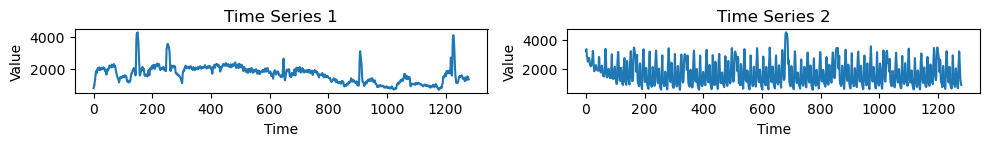

In [8]:
# Plot the first 10 time series
plt.figure(figsize=(10, 6))
for i in range(2):
    plt.subplot(5, 2, i+1)  # 5 rows, 2 columns, i+1 is the plot index
    plt.plot(X[i][0])  # Assuming X is a list of lists where each inner list contains a single time series
    plt.title(f"Time Series {i+1}")
    plt.xlabel("Time")
    plt.ylabel("Value")
plt.tight_layout()
plt.show()

In [9]:
len_threshold = 1280   #cause >1280 no infos in ts 

## Loading TS

In [10]:
# Ottieni i valori unici e le loro frequenze
valori_unici, conteggi = np.unique(y, return_counts=True)

# Stampare il numero di volte che ogni classe appare
for classe, conteggio in zip(valori_unici, conteggi):
    print(f"{classe}: {conteggio}")

emo: 500
folk: 500
goth: 500
happy: 500
heavy-metal: 500
honky-tonk: 500
j-idol: 500
kids: 500
minimal-techno: 500
mpb: 500
new-age: 500
opera: 500
piano: 500
progressive-house: 500
salsa: 500
sertanejo: 500
sleep: 500
songwriter: 500
synth-pop: 500
world-music: 500


In [11]:
import numpy as np

# Conta il numero di generi unici presenti nella lista y
unique_genres = np.unique(y)
num_unique_genres = len(unique_genres)

print("Numero di generi unici:", num_unique_genres)
print('generi unici:', unique_genres)


Numero di generi unici: 20
generi unici: ['emo' 'folk' 'goth' 'happy' 'heavy-metal' 'honky-tonk' 'j-idol' 'kids'
 'minimal-techno' 'mpb' 'new-age' 'opera' 'piano' 'progressive-house'
 'salsa' 'sertanejo' 'sleep' 'songwriter' 'synth-pop' 'world-music']


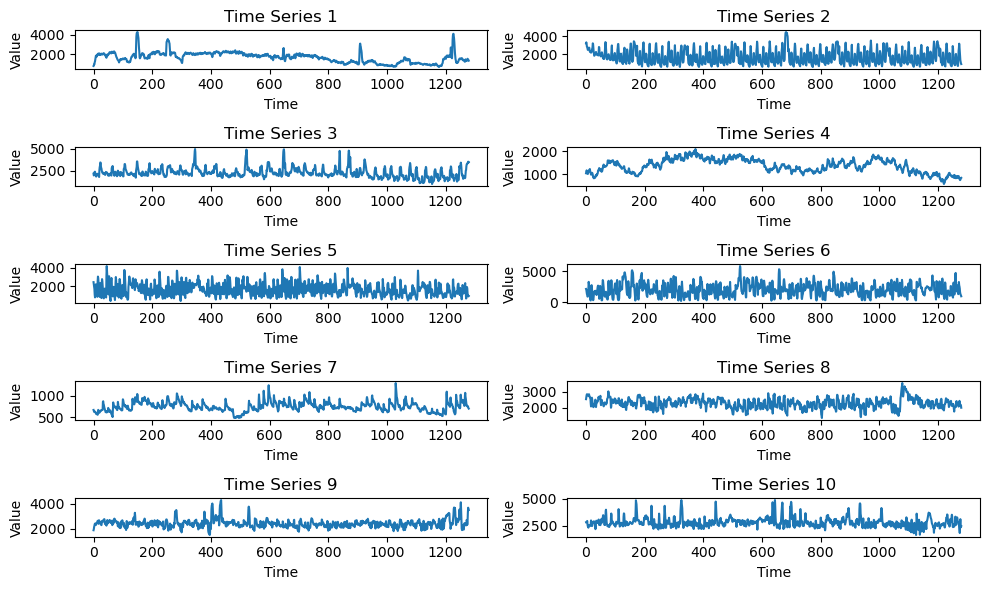

In [12]:
# Plot the first 10 time series
plt.figure(figsize=(10, 6))
for i in range(10):
    plt.subplot(5, 2, i+1)  # 5 rows, 2 columns, i+1 is the plot index
    plt.plot(X[i][0])  # Assuming X is a list of lists where each inner list contains a single time series
    plt.title(f"Time Series {i+1}")
    plt.xlabel("Time")
    plt.ylabel("Value")
plt.tight_layout()
plt.show()

## Trasformazioni (amplitude scaling, noise) win size= 100

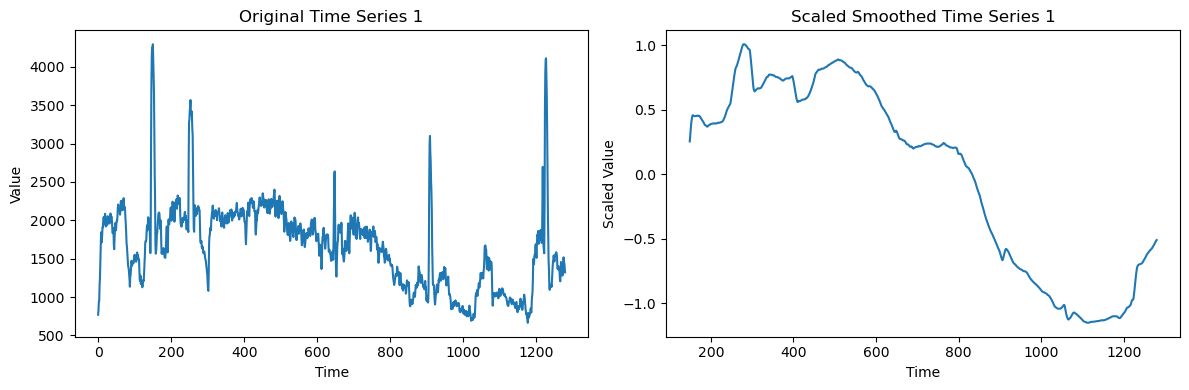

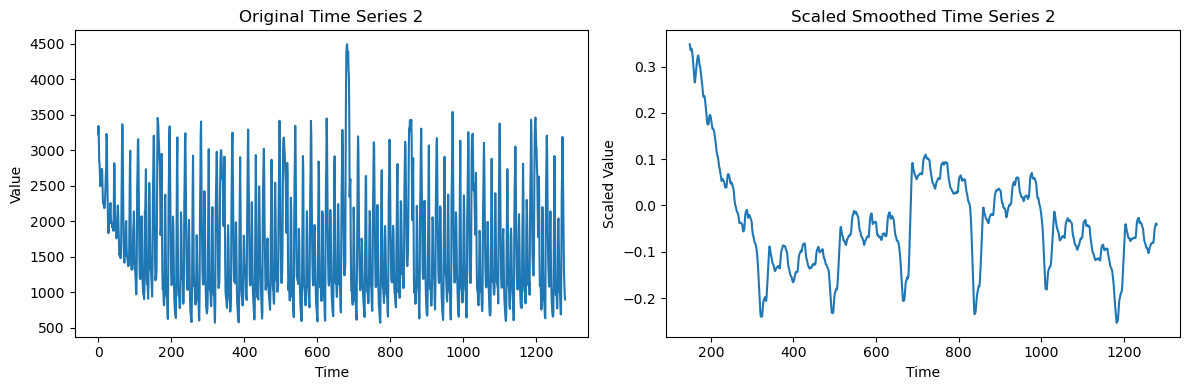

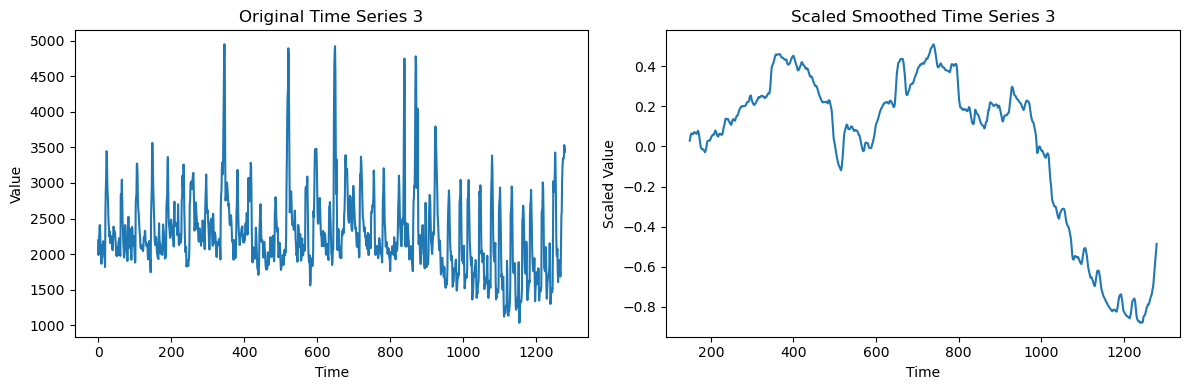

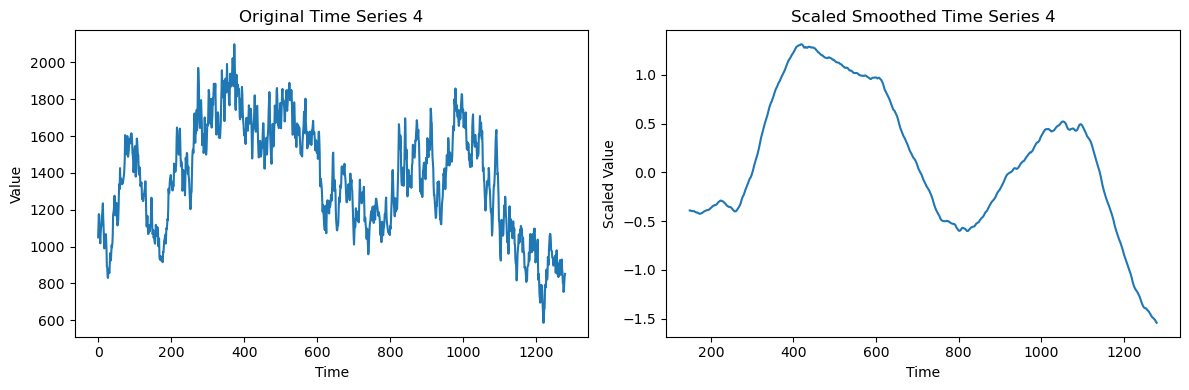

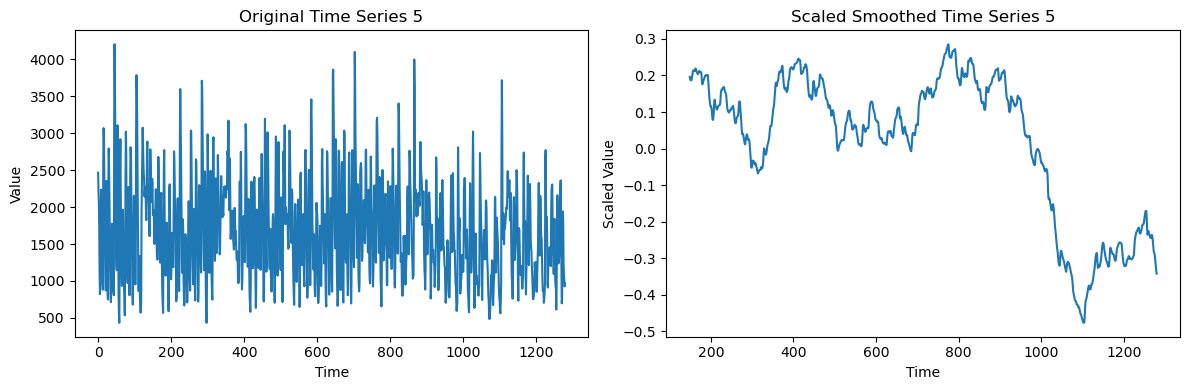

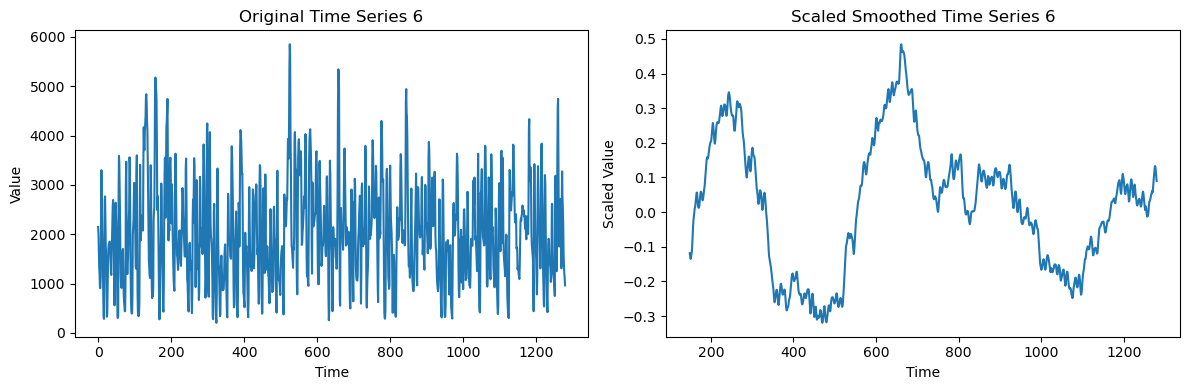

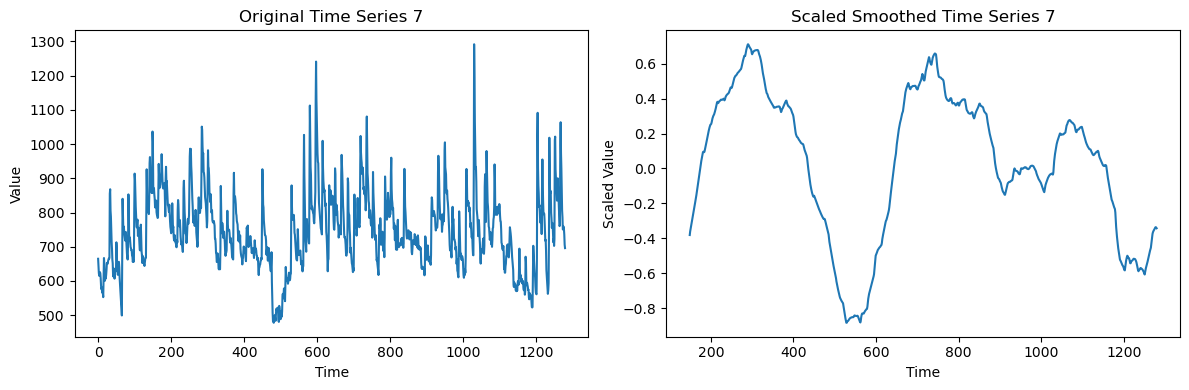

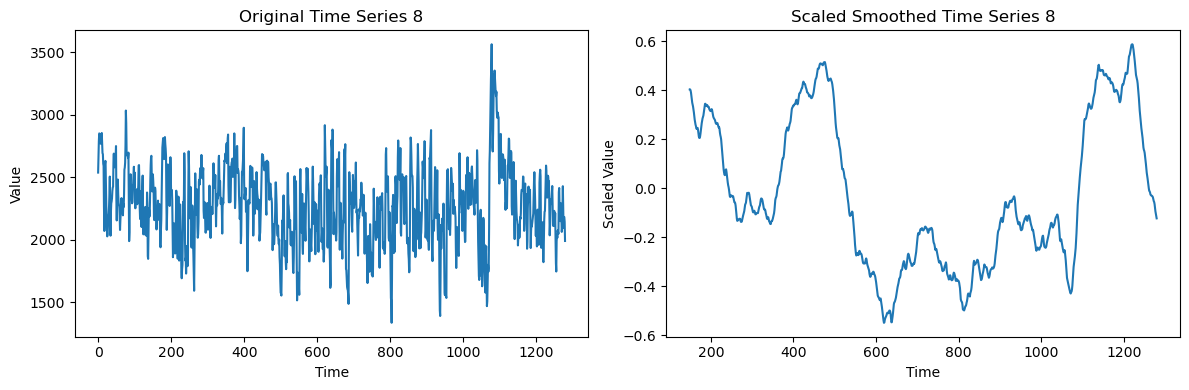

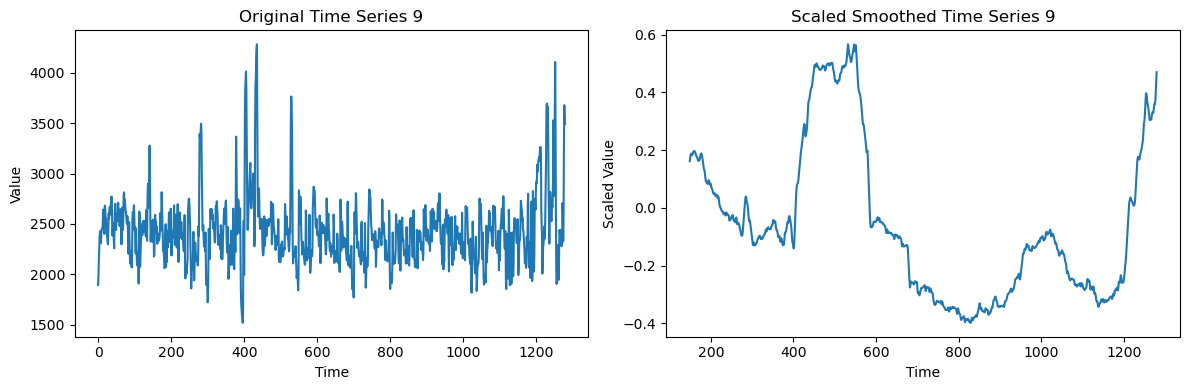

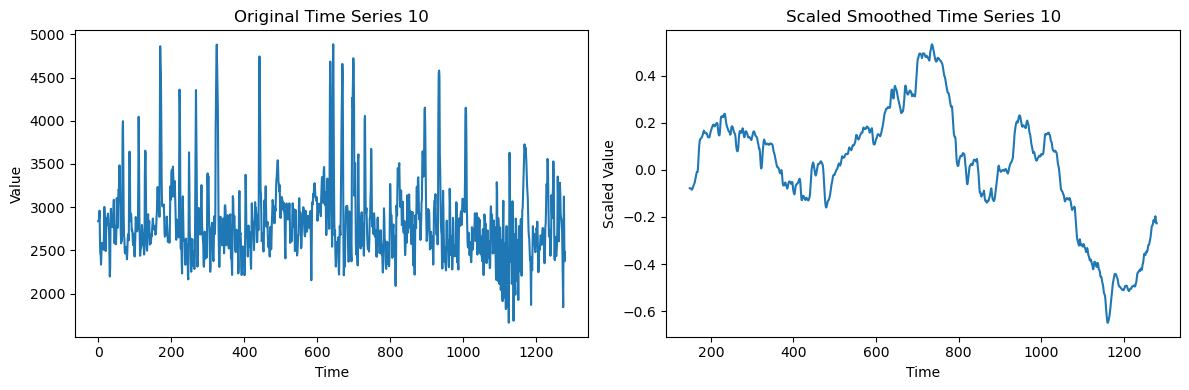

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Define window size for rolling mean
w = 150

# Assume X contains the time series data for the first 10 time series
scaler = StandardScaler()

for i in range(10):
    ts = X[i][0]  # Assuming X is a list of lists where each inner list contains a single time series
    
    # Scale the time series
    tss = scaler.fit_transform(np.array(ts).reshape(-1, 1))
    
    # Mean centering and standardization
    ts_scaled = ((tss - tss.mean()) / tss.std())
    
    # Apply rolling window mean
    ts_smoothed = pd.Series(ts_scaled.squeeze()).rolling(window=w).mean()
    
    # Plot comparison subplot
    plt.figure(figsize=(12, 4))
    
    # Plot original time series
    plt.subplot(1, 2, 1)
    plt.plot(ts)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.title(f"Original Time Series {i+1}")
    
    # Plot scaled and smoothed time series
    plt.subplot(1, 2, 2)
    plt.plot(ts_smoothed)
    plt.xlabel("Time")
    plt.ylabel("Scaled Value")
    plt.title(f"Scaled Smoothed Time Series {i+1}")
    
    plt.tight_layout()
    plt.show()


# Reconstruct Error on PAA approx

In [14]:
from sktime.transformations.panel.dictionary_based import PAA

In [15]:
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler

# Define your time series data in X

# Define window size for rolling mean
w_values = [5, 10, 100, 150, 180, 250]

original_series_list = []
scaled_series_list = []
smoothed_series_list = []
euclidean_distance_list = []

min_distance = float('inf')  # Initialize min_distance with infinity
best_w = None

for w in w_values:
    scaled_series_per_w = []  # List to store scaled series for the current window size
    smoothed_series_per_w = []  # List to store smoothed series for the current window size
    original_series_per_w = []  # List to store reconstructed series for the current window size
    
    distance_sum = 0
    for i in range(len(X)):
        ts = X[i][0]  # Assuming X is a list of time series
        
        # Scale the time series
        scaler = StandardScaler()
        tss = scaler.fit_transform(np.array(ts).reshape(-1, 1))
        
        # Mean centering and standardization (amplitude scaling)
        ts_scaled = ((tss - tss.mean()) / tss.std())
        
        # Apply rolling window mean (noise)
        ts_smoothed = pd.Series(ts_scaled.squeeze()).rolling(window=w, min_periods=1).mean()
            
        # Capture noise (difference between scaled and smoothed series)
        noise = ts_scaled.squeeze() - ts_smoothed
        
        # Reconstruct the original time series by adding back the noise
        original_series = ts_smoothed + noise

        # Append the current time series to the lists for the current window size
        scaled_series_per_w.append(ts_scaled)
        smoothed_series_per_w.append(ts_smoothed)
        original_series_per_w.append(original_series)

        
        # Calculate Euclidean distance between original and smoothed time series
        distance = pairwise_distances(ts_scaled.flatten().reshape(1, -1), np.array(original_series).flatten().reshape(1, -1), metric='euclidean')
        distance_sum += distance

    # Calculate average Euclidean distance for the current window size
    avg_distance = distance_sum / len(X)
    euclidean_distance_list.append(avg_distance)
    
    # Update min_distance and best_w if the current average distance is smaller than min_distance
    if avg_distance < min_distance:
        min_distance = avg_distance
        best_w = w
        
    # Append the lists for the current window size to the main lists
    scaled_series_list.append(scaled_series_per_w)
    smoothed_series_list.append(smoothed_series_per_w)
    original_series_list.append(original_series_per_w)

# Print best window size and corresponding minimum Euclidean distance
print("Best window size:", best_w)
print("Minimum Euclidean distance:", min_distance)


Best window size: 5
Minimum Euclidean distance: [[4.59314432e-07]]


In [16]:
# Find the index of the best window size in w_values
best_w_index = w_values.index(best_w)

w = 150

# Select the lists corresponding to the best window size
best_scaled_series_list = scaled_series_list[best_w_index]
best_smoothed_series_list = smoothed_series_list[best_w_index]
best_original_series_list = original_series_list[best_w_index]

# Now you can use best_scaled_series_list, best_smoothed_series_list, and best_original_series_list
# for further analysis or visualization

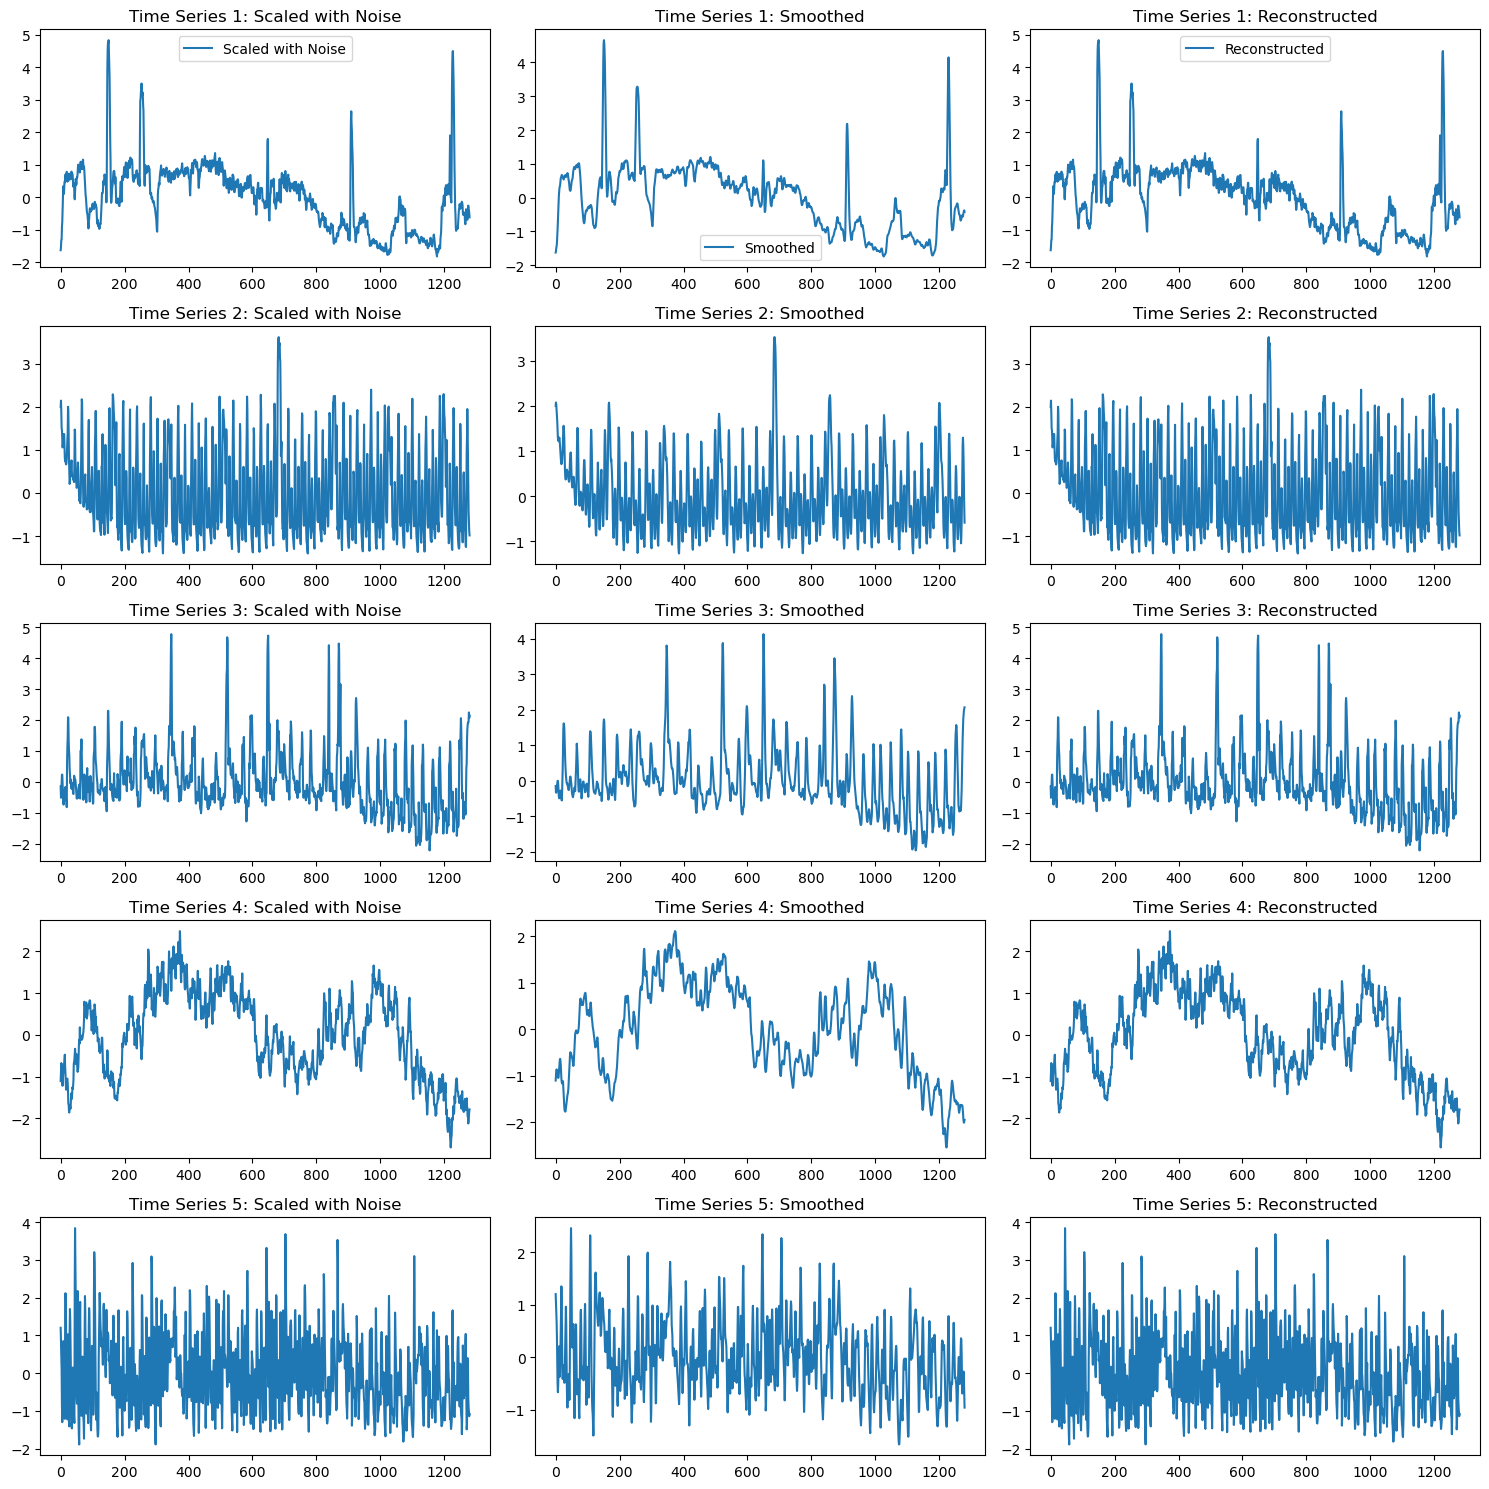

In [17]:
# Plot the scaled time series with noise and the reconstructed time series side by side
num_series_to_plot = (5)  # Plot at most 50 time series or the number available
num_plots = 3  # Three plots per time series: scaled with noise, smoothed, and reconstructed

if num_series_to_plot > 0:
    plt.figure(figsize=(15, num_series_to_plot*3))

    for i in range(num_series_to_plot):
        for j in range(num_plots):
            plt.subplot(num_series_to_plot, num_plots, i * num_plots + j + 1)
            if j == 0:
                plt.plot(best_scaled_series_list[i], label='Scaled with Noise')
                plt.title(f'Time Series {i+1}: Scaled with Noise')
            elif j == 1:
                plt.plot(best_smoothed_series_list[i], label='Smoothed')
                plt.title(f'Time Series {i+1}: Smoothed')
            else:
                plt.plot(best_original_series_list[i], label='Reconstructed')
                plt.title(f'Time Series {i+1}: Reconstructed')
            if i == 0:
                plt.legend()

    plt.tight_layout()
    plt.show()
else:
    print("No time series available for plotting.")


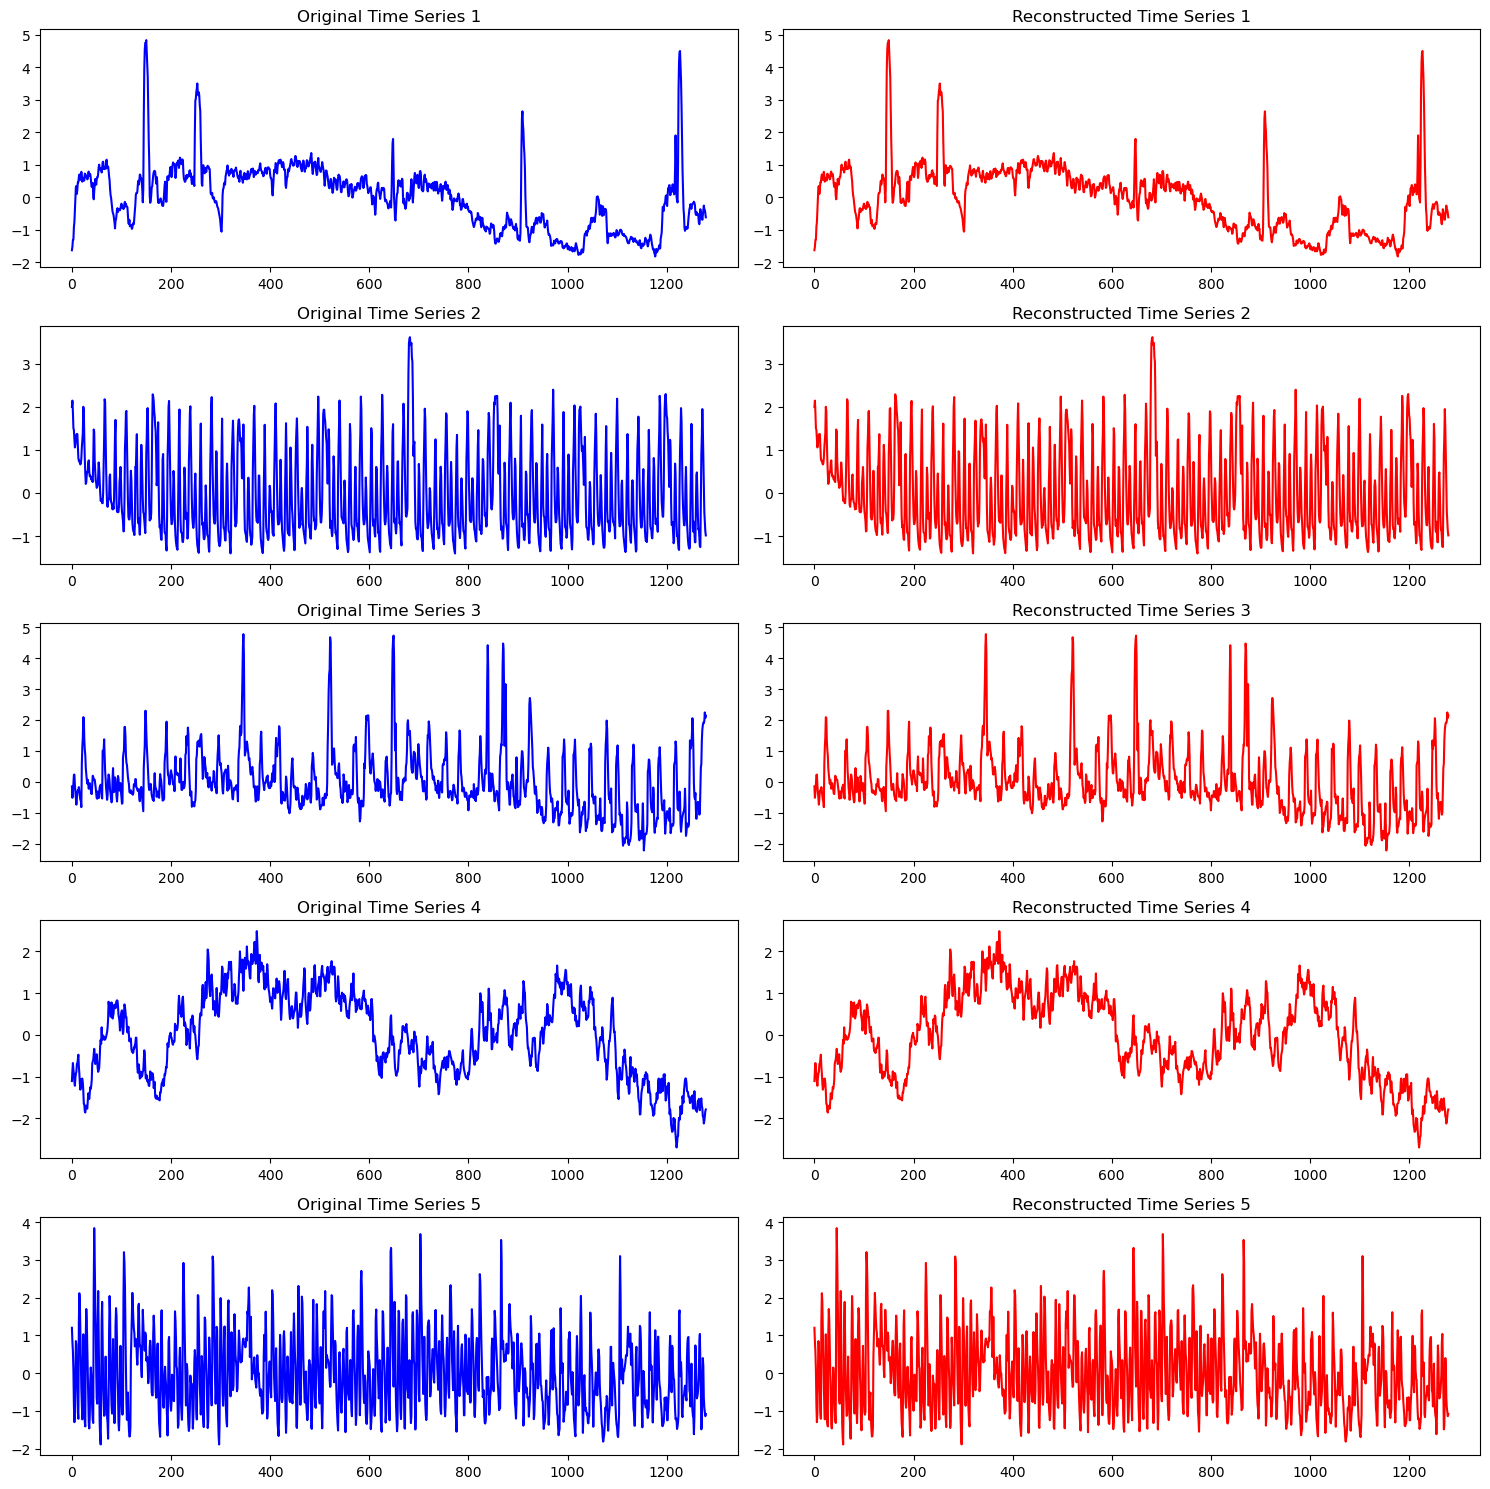

In [18]:
import matplotlib.pyplot as plt

# Assuming original_series_list contains the reconstructed original time series
# and X contains the original time series data

# Plotting the time series side by side
num_samples = 5  # Number of time series to plot

fig, axs = plt.subplots(num_samples, 2, figsize=(15, num_samples*3))

for i in range(num_samples):
    # Original time series
    axs[i, 0].plot(best_scaled_series_list[i], color='blue', label='Original')
    axs[i, 0].set_title('Original Time Series ' + str(i+1))
    
    # Reconstructed time series
    axs[i, 1].plot(best_original_series_list[i], color='red', label='Reconstructed')
    axs[i, 1].set_title('Reconstructed Time Series ' + str(i+1))

plt.tight_layout()
plt.show()


## Find best PAA intervals¶

The best interval value is: 160
Minimum euclidean distance: 1.052249163613103


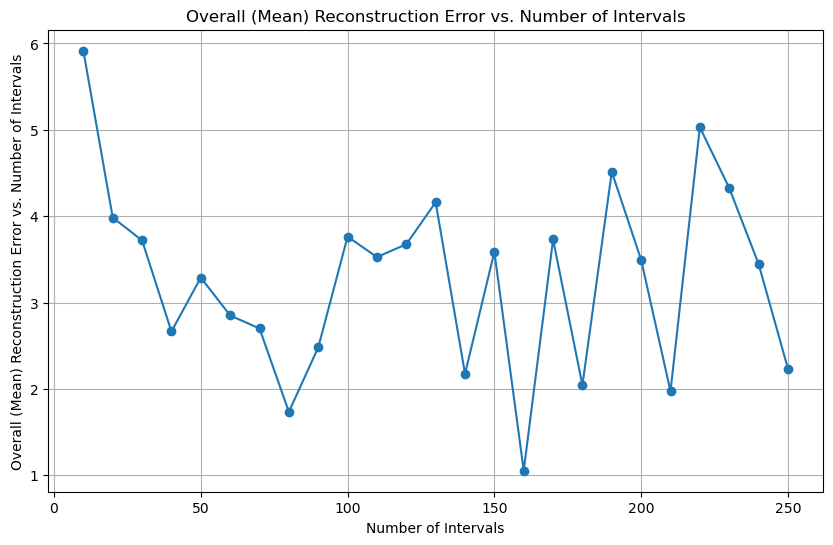

In [19]:
from tslearn.piecewise import PiecewiseAggregateApproximation
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import euclidean

# Define a function to calculate Euclidean distance
def calculate_euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2))

# Initialize a list to store average distances for different values of num_intervals
avg_distances = []

# Initialize a list to store the distances for the best interval
distances_for_best_interval = []

# Iterate over each time series in X
for series_list in X:

    # Initialize a list to store average distances for different values of num_intervals for the current series
    avg_distances_series = []

    # Try different values of num_intervals
    for num_intervals in range(10, 251, 10):  # Try intervals from 10 to 250

        # Select the first time series
        ts = series_list[0]  # Assuming each series_list contains a single time series

        # Scale the time series
        tss = scaler.fit_transform(np.array(ts).reshape(-1, 1))

        # Mean centering and standardization (amplitude scaling)
        ts_scaled = ((tss - tss.mean()) / tss.std())

        # Apply rolling window mean (noise)
        ts_smoothed = pd.Series(ts_scaled.squeeze()).rolling(window=w, min_periods=1).mean()

        # New dataframe for ts_smoothed
        df = pd.DataFrame(ts_smoothed)
        df_values = df.values.reshape(1, -1, 1)  # Reshape to 3D array (n_samples, n_timestamps, n_features)

        # Perform Piecewise Aggregate Approximation (PAA)
        paa = PiecewiseAggregateApproximation(n_segments=num_intervals)
        ts_paa = paa.fit_transform(df_values)

        # Invert PAA transformation
        inverse_paa = paa.inverse_transform(ts_paa)

        # Invert scaling transformation
        reconstructed_series = inverse_paa.squeeze()

        # Calculate Euclidean distance between smoothed and reconstructed time series
        distance = calculate_euclidean_distance(ts_smoothed, reconstructed_series)

        # Append the distance to the list
        avg_distances_series.append(distance)

    # Append the average distances for the current series to the overall list
    avg_distances.append(avg_distances_series)

# Calculate the overall average distances across all time series for each num_intervals
overall_avg_distances = np.mean(avg_distances, axis=0)

# Find the index of the minimum overall average Euclidean distance
best_interval_index = np.argmin(overall_avg_distances)

# Calculate the corresponding best num_intervals
best_interval = 10 + best_interval_index * 10  # Because the intervals start from 10 and increase by 10

# Obtain the minimum Euclidean distance
min_euclidean_distance = overall_avg_distances[best_interval_index]

# Print the best interval value and the corresponding minimum Euclidean distance
print("The best interval value is:", best_interval)
print("Minimum euclidean distance:", min_euclidean_distance)

# Plot the overall average distances for different values of num_intervals
plt.figure(figsize=(10, 6))
plt.plot(range(10, 251, 10), overall_avg_distances, marker='o', linestyle='-')
plt.title('Overall (Mean) Reconstruction Error vs. Number of Intervals')
plt.xlabel('Number of Intervals')
plt.ylabel('Overall (Mean) Reconstruction Error vs. Number of Intervals')
plt.grid(True)
plt.show()


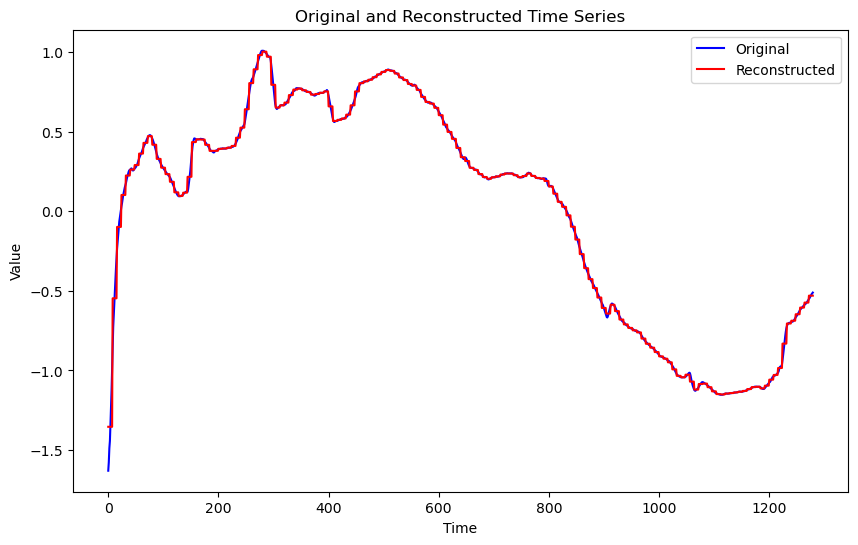

In [20]:
# Define window size for rolling mean
w = 150  # Best value from previous studies

# best value from previous studies
num_intervals = 160

# Select one time series from X
ts = X[0][0]  # Assuming X is a list of lists where each inner list contains a single time series

# Initialize scaler
scaler = StandardScaler()

# Scale the time series
tss = scaler.fit_transform(np.array(ts).reshape(-1, 1))

# Mean centering and standardization (amplitude scaling)
ts_scaled = ((tss - tss.mean()) / tss.std())

# Apply rolling window mean (noise)
ts_smoothed = pd.Series(ts_scaled.squeeze()).rolling(window=w, min_periods=1).mean()

# New dataframe for ts_smoothed
df = pd.DataFrame(ts_smoothed)
df_values = df.values.reshape(1, -1, 1)  # Reshape to 3D array (n_samples, n_timestamps, n_features)

# Perform Piecewise Aggregate Approximation (PAA)
paa = PiecewiseAggregateApproximation(n_segments=num_intervals)
ts_paa = paa.fit_transform(df_values)

# Invert PAA transformation
inverse_paa = paa.inverse_transform(ts_paa)

# Invert scaling transformation
reconstructed_series = inverse_paa.squeeze()

# Plot original and reconstructed time series
plt.figure(figsize=(10, 6))
plt.plot(ts_smoothed, label='Original', color='blue')
plt.plot(reconstructed_series, label='Reconstructed', color='red')
plt.title('Original and Reconstructed Time Series')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()


## Preprocess TS with best values so far

In [21]:
w=150 
best_intervals=160 # from past studies
ts_paa_list = []

for i in range(len(X)):
        ts = X[i][0]  # Assuming X is a list of lists where each inner list contains a single time series

        # Scale the time series
        tss = scaler.fit_transform(np.array(ts).reshape(-1, 1))

        # Mean centering and standardization (amplitude scaling)
        ts_scaled = ((tss - tss.mean()) / tss.std())

        # Apply rolling window mean (noise)
        ts_smoothed = pd.Series(ts_scaled.squeeze()).rolling(window=w, min_periods=1).mean()

        # Perform Piecewise Aggregate Approximation (PAA)
        paa = PAA(num_intervals=best_intervals)
        ts_paa = paa.fit_transform(pd.DataFrame(ts_smoothed)).iloc[:, 0].values
        ts_paa_list.append([ts_paa])

In [22]:
ts_paa_vect = np.array(ts_paa_list)

In [23]:
ts_paa_vect.shape

(10000, 1, 160)

In [24]:
# salva serie temporali normalizzate
#salvo i valori ottenuti
import numpy as np
import pandas as pd

# Assume che X, y e ids siano già definiti

# Salva i numpy array separatamente
#np.save('X_finale_normalizzato_totali.npy', ts_paa_vect)
#np.save('y_finale_normalizzato_totali.npy', y)
#np.save('ids_finale_normalizzato_totali.npy', ids)



## Una volta salvati per eseguire successivamente si fa il load 

In [2]:
# Carica i dati
X = np.load('X_finale_normalizzato_100.npy')
y = np.load('y_finale_normalizzato_100.npy')
ids = np.load('ids_finale_normalizzato_100.npy')

## DTW

In [3]:
from sktime.clustering.k_means import TimeSeriesKMeans
from sktime.utils.plotting import plot_series
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [5]:
X.shape

(2000, 1, 160)

In [50]:
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from sklearn.preprocessing import StandardScaler

# Assuming you have your emissions data loaded into a numpy array called 'emissions'


# Step 2: Perform clustering using TimeSeriesKMeans
k_range = range(2, 5)
clustering_results = []
for k in k_range:
    model = TimeSeriesKMeans(n_clusters=k, metric="dtw", distance_params={"itakura_max_slope": 1.0}, verbose=False, random_state=42)
    model.fit(X)
    clustering_results.append((k, model.inertia_, model.labels_))

# You can access the cluster labels using 'clustering_results[i][2]' for the i-th k value
# 'inertia_' gives you the sum of squared distances of samples to their closest cluster center, a measure of how compact the clusters are.


In [51]:
clustering_results


[(2, 28814.983075505337, array([1, 1, 1, ..., 0, 1, 0])),
 (3, 24459.74475454023, array([1, 0, 1, ..., 2, 0, 2])),
 (4, 22300.776075107256, array([2, 2, 2, ..., 1, 0, 1]))]

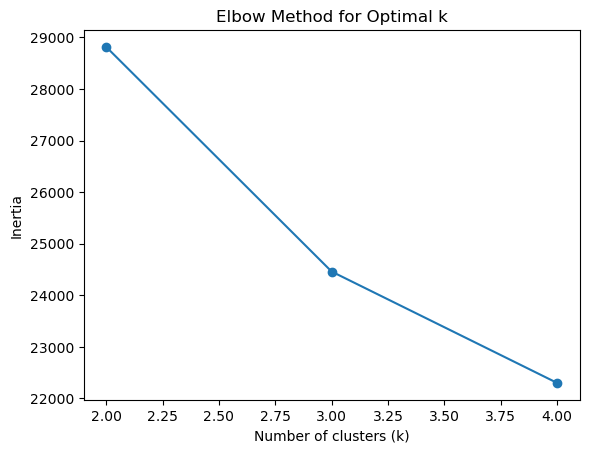

In [52]:
import matplotlib.pyplot as plt

# Estrai i valori di k, inertia e labels dalla lista clustering_results
k_values = [result[0] for result in clustering_results]
inertia_values = [result[1] for result in clustering_results]

# Traccia l'inertia in funzione di k
plt.plot(k_values, inertia_values, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()


In [53]:
clusterer = TimeSeriesKMeans(n_clusters=3, metric="dtw", distance_params={"itakura_max_slope": 1.0}, verbose=True)


In [54]:
y

array(['opera', 'minimal-techno', 'goth', ..., 'salsa', 'salsa',
       'songwriter'], dtype='<U17')

In [65]:
%%time
clusterer.fit(X)

Iteration 0, inertia 40251.48103774318.
Iteration 1, inertia 26594.830244535966.
Iteration 2, inertia 24653.132541090585.
Iteration 3, inertia 24567.758020248515.
Iteration 4, inertia 24614.113346654703.
Iteration 5, inertia 24933.61786336144.
Iteration 6, inertia 24767.496996382557.
Iteration 7, inertia 24578.05395916235.
Iteration 8, inertia 24437.441946846368.
Iteration 9, inertia 24661.949916276026.
Iteration 10, inertia 24899.74372211125.
Iteration 11, inertia 25168.594999959303.
Iteration 12, inertia 25439.790761903758.
Iteration 13, inertia 25487.949085445056.
Iteration 14, inertia 25299.1539521401.
Iteration 15, inertia 25169.502221897696.
Iteration 16, inertia 25167.670788902127.
Iteration 17, inertia 25236.598192000118.
Iteration 18, inertia 25382.231643971398.
Iteration 19, inertia 25586.409129223248.
Iteration 20, inertia 25944.059489349973.
Iteration 21, inertia 26053.688290653554.
Iteration 22, inertia 25435.401194355574.
Iteration 23, inertia 24659.801748068727.
Iteratio

Iteration 195, inertia 25906.131581554204.
Iteration 196, inertia 26149.77959456238.
Iteration 197, inertia 25583.092631756695.
Iteration 198, inertia 24787.593170013322.
Iteration 199, inertia 24459.74475454023.
Iteration 200, inertia 24558.429542817263.
Iteration 201, inertia 24593.196856172162.
Iteration 202, inertia 24916.960602918833.
Iteration 203, inertia 24791.704519464794.
Iteration 204, inertia 24650.42185960868.
Iteration 205, inertia 24435.678479561993.
Iteration 206, inertia 24632.685917939423.
Iteration 207, inertia 24858.850691880376.
Iteration 208, inertia 25132.672403192366.
Iteration 209, inertia 25420.10528914864.
Iteration 210, inertia 25524.69145526657.
Iteration 211, inertia 25329.511012546493.
Iteration 212, inertia 25248.163692901868.
Iteration 213, inertia 25201.853808126347.
Iteration 214, inertia 25235.90441076059.
Iteration 215, inertia 25376.377280368615.
Iteration 216, inertia 25579.666685427233.
Iteration 217, inertia 25906.131581554204.
Iteration 218, in

Iteration 90, inertia 24650.42185960868.
Iteration 91, inertia 24435.678479561993.
Iteration 92, inertia 24632.685917939423.
Iteration 93, inertia 24858.850691880376.
Iteration 94, inertia 25132.672403192366.
Iteration 95, inertia 25420.10528914864.
Iteration 96, inertia 25524.69145526657.
Iteration 97, inertia 25329.511012546493.
Iteration 98, inertia 25248.163692901868.
Iteration 99, inertia 25201.853808126347.
Iteration 100, inertia 25235.90441076059.
Iteration 101, inertia 25376.377280368615.
Iteration 102, inertia 25579.666685427233.
Iteration 103, inertia 25906.131581554204.
Iteration 104, inertia 26149.77959456238.
Iteration 105, inertia 25583.092631756695.
Iteration 106, inertia 24787.593170013322.
Iteration 107, inertia 24459.74475454023.
Iteration 108, inertia 24558.429542817263.
Iteration 109, inertia 24593.196856172162.
Iteration 110, inertia 24916.960602918833.
Iteration 111, inertia 24791.704519464794.
Iteration 112, inertia 24650.42185960868.
Iteration 113, inertia 24435

Iteration 282, inertia 24787.593170013322.
Iteration 283, inertia 24459.74475454023.
Iteration 284, inertia 24558.429542817263.
Iteration 285, inertia 24593.196856172162.
Iteration 286, inertia 24916.960602918833.
Iteration 287, inertia 24791.704519464794.
Iteration 288, inertia 24650.42185960868.
Iteration 289, inertia 24435.678479561993.
Iteration 290, inertia 24632.685917939423.
Iteration 291, inertia 24858.850691880376.
Iteration 292, inertia 25132.672403192366.
Iteration 293, inertia 25420.10528914864.
Iteration 294, inertia 25524.69145526657.
Iteration 295, inertia 25329.511012546493.
Iteration 296, inertia 25248.163692901868.
Iteration 297, inertia 25201.853808126347.
Iteration 298, inertia 25235.90441076059.
Iteration 299, inertia 25376.377280368615.
Iteration 0, inertia 40134.295117662725.
Iteration 1, inertia 26167.770183367662.
Iteration 2, inertia 24816.196509996127.
Iteration 3, inertia 24448.783749343904.
Iteration 4, inertia 24641.54785729776.
Iteration 5, inertia 24872.

Iteration 177, inertia 24791.704519464794.
Iteration 178, inertia 24650.42185960868.
Iteration 179, inertia 24435.678479561993.
Iteration 180, inertia 24632.685917939423.
Iteration 181, inertia 24858.850691880376.
Iteration 182, inertia 25132.672403192366.
Iteration 183, inertia 25420.10528914864.
Iteration 184, inertia 25524.69145526657.
Iteration 185, inertia 25329.511012546493.
Iteration 186, inertia 25248.163692901868.
Iteration 187, inertia 25201.853808126347.
Iteration 188, inertia 25235.90441076059.
Iteration 189, inertia 25376.377280368615.
Iteration 190, inertia 25579.666685427233.
Iteration 191, inertia 25906.131581554204.
Iteration 192, inertia 26149.77959456238.
Iteration 193, inertia 25583.092631756695.
Iteration 194, inertia 24787.593170013322.
Iteration 195, inertia 24459.74475454023.
Iteration 196, inertia 24558.429542817263.
Iteration 197, inertia 24593.196856172162.
Iteration 198, inertia 24916.960602918833.
Iteration 199, inertia 24791.704519464794.
Iteration 200, in

Iteration 71, inertia 24433.955958891074.
Iteration 72, inertia 24623.01361190218.
Iteration 73, inertia 24841.807209278726.
Iteration 74, inertia 25115.341520379836.
Iteration 75, inertia 25424.510817816394.
Iteration 76, inertia 25515.545775732324.
Iteration 77, inertia 25309.08645633857.
Iteration 78, inertia 25225.999544643382.
Iteration 79, inertia 25202.377033258796.
Iteration 80, inertia 25228.221144724597.
Iteration 81, inertia 25384.716758327624.
Iteration 82, inertia 25607.28841354595.
Iteration 83, inertia 25896.60846076101.
Iteration 84, inertia 26119.382006297645.
Iteration 85, inertia 25541.393103361108.
Iteration 86, inertia 24750.57047130132.
Iteration 87, inertia 24462.843275009684.
Iteration 88, inertia 24557.644135562885.
Iteration 89, inertia 24584.272318890922.
Iteration 90, inertia 24916.960602918833.
Iteration 91, inertia 24791.704519464794.
Iteration 92, inertia 24650.42185960868.
Iteration 93, inertia 24435.678479561993.
Iteration 94, inertia 24632.685917939423

Iteration 264, inertia 24558.429542817263.
Iteration 265, inertia 24593.196856172162.
Iteration 266, inertia 24916.960602918833.
Iteration 267, inertia 24791.704519464794.
Iteration 268, inertia 24650.42185960868.
Iteration 269, inertia 24435.678479561993.
Iteration 270, inertia 24632.685917939423.
Iteration 271, inertia 24858.850691880376.
Iteration 272, inertia 25132.672403192366.
Iteration 273, inertia 25420.10528914864.
Iteration 274, inertia 25524.69145526657.
Iteration 275, inertia 25329.511012546493.
Iteration 276, inertia 25248.163692901868.
Iteration 277, inertia 25201.853808126347.
Iteration 278, inertia 25235.90441076059.
Iteration 279, inertia 25376.377280368615.
Iteration 280, inertia 25579.666685427233.
Iteration 281, inertia 25906.131581554204.
Iteration 282, inertia 26149.77959456238.
Iteration 283, inertia 25583.092631756695.
Iteration 284, inertia 24787.593170013322.
Iteration 285, inertia 24459.74475454023.
Iteration 286, inertia 24558.429542817263.
Iteration 287, in

Iteration 159, inertia 24593.196856172162.
Iteration 160, inertia 24916.960602918833.
Iteration 161, inertia 24791.704519464794.
Iteration 162, inertia 24650.42185960868.
Iteration 163, inertia 24435.678479561993.
Iteration 164, inertia 24632.685917939423.
Iteration 165, inertia 24858.850691880376.
Iteration 166, inertia 25132.672403192366.
Iteration 167, inertia 25420.10528914864.
Iteration 168, inertia 25524.69145526657.
Iteration 169, inertia 25329.511012546493.
Iteration 170, inertia 25248.163692901868.
Iteration 171, inertia 25201.853808126347.
Iteration 172, inertia 25235.90441076059.
Iteration 173, inertia 25376.377280368615.
Iteration 174, inertia 25579.666685427233.
Iteration 175, inertia 25906.131581554204.
Iteration 176, inertia 26149.77959456238.
Iteration 177, inertia 25583.092631756695.
Iteration 178, inertia 24787.593170013322.
Iteration 179, inertia 24459.74475454023.
Iteration 180, inertia 24558.429542817263.
Iteration 181, inertia 24593.196856172162.
Iteration 182, in

Iteration 53, inertia 24623.01361190218.
Iteration 54, inertia 24841.807209278726.
Iteration 55, inertia 25115.341520379836.
Iteration 56, inertia 25424.510817816394.
Iteration 57, inertia 25515.545775732324.
Iteration 58, inertia 25309.08645633857.
Iteration 59, inertia 25225.999544643382.
Iteration 60, inertia 25202.377033258796.
Iteration 61, inertia 25228.221144724597.
Iteration 62, inertia 25384.716758327624.
Iteration 63, inertia 25607.28841354595.
Iteration 64, inertia 25896.60846076101.
Iteration 65, inertia 26119.382006297645.
Iteration 66, inertia 25541.393103361108.
Iteration 67, inertia 24750.57047130132.
Iteration 68, inertia 24462.843275009684.
Iteration 69, inertia 24557.644135562885.
Iteration 70, inertia 24584.272318890922.
Iteration 71, inertia 24916.960602918833.
Iteration 72, inertia 24791.704519464794.
Iteration 73, inertia 24650.42185960868.
Iteration 74, inertia 24435.678479561993.
Iteration 75, inertia 24632.685917939423.
Iteration 76, inertia 24858.850691880376

Iteration 246, inertia 24593.196856172162.
Iteration 247, inertia 24916.960602918833.
Iteration 248, inertia 24791.704519464794.
Iteration 249, inertia 24650.42185960868.
Iteration 250, inertia 24435.678479561993.
Iteration 251, inertia 24632.685917939423.
Iteration 252, inertia 24858.850691880376.
Iteration 253, inertia 25132.672403192366.
Iteration 254, inertia 25420.10528914864.
Iteration 255, inertia 25524.69145526657.
Iteration 256, inertia 25329.511012546493.
Iteration 257, inertia 25248.163692901868.
Iteration 258, inertia 25201.853808126347.
Iteration 259, inertia 25235.90441076059.
Iteration 260, inertia 25376.377280368615.
Iteration 261, inertia 25579.666685427233.
Iteration 262, inertia 25906.131581554204.
Iteration 263, inertia 26149.77959456238.
Iteration 264, inertia 25583.092631756695.
Iteration 265, inertia 24787.593170013322.
Iteration 266, inertia 24459.74475454023.
Iteration 267, inertia 24558.429542817263.
Iteration 268, inertia 24593.196856172162.
Iteration 269, in

Iteration 141, inertia 24462.843275009684.
Iteration 142, inertia 24557.644135562885.
Iteration 143, inertia 24584.272318890922.
Iteration 144, inertia 24916.960602918833.
Iteration 145, inertia 24791.704519464794.
Iteration 146, inertia 24650.42185960868.
Iteration 147, inertia 24435.678479561993.
Iteration 148, inertia 24632.685917939423.
Iteration 149, inertia 24858.850691880376.
Iteration 150, inertia 25132.672403192366.
Iteration 151, inertia 25420.10528914864.
Iteration 152, inertia 25524.69145526657.
Iteration 153, inertia 25329.511012546493.
Iteration 154, inertia 25248.163692901868.
Iteration 155, inertia 25201.853808126347.
Iteration 156, inertia 25235.90441076059.
Iteration 157, inertia 25376.377280368615.
Iteration 158, inertia 25579.666685427233.
Iteration 159, inertia 25906.131581554204.
Iteration 160, inertia 26149.77959456238.
Iteration 161, inertia 25583.092631756695.
Iteration 162, inertia 24787.593170013322.
Iteration 163, inertia 24459.74475454023.
Iteration 164, in

Iteration 34, inertia 25424.510817816394.
Iteration 35, inertia 25515.545775732324.
Iteration 36, inertia 25309.08645633857.
Iteration 37, inertia 25225.999544643382.
Iteration 38, inertia 25202.377033258796.
Iteration 39, inertia 25228.221144724597.
Iteration 40, inertia 25384.716758327624.
Iteration 41, inertia 25607.28841354595.
Iteration 42, inertia 25896.60846076101.
Iteration 43, inertia 26119.382006297645.
Iteration 44, inertia 25541.393103361108.
Iteration 45, inertia 24750.57047130132.
Iteration 46, inertia 24462.843275009684.
Iteration 47, inertia 24557.644135562885.
Iteration 48, inertia 24584.272318890922.
Iteration 49, inertia 24916.960602918833.
Iteration 50, inertia 24791.704519464794.
Iteration 51, inertia 24650.42185960868.
Iteration 52, inertia 24435.678479561993.
Iteration 53, inertia 24632.685917939423.
Iteration 54, inertia 24858.850691880376.
Iteration 55, inertia 25132.672403192366.
Iteration 56, inertia 25420.10528914864.
Iteration 57, inertia 25524.69145526657.

Iteration 228, inertia 24435.678479561993.
Iteration 229, inertia 24632.685917939423.
Iteration 230, inertia 24858.850691880376.
Iteration 231, inertia 25132.672403192366.
Iteration 232, inertia 25420.10528914864.
Iteration 233, inertia 25524.69145526657.
Iteration 234, inertia 25329.511012546493.
Iteration 235, inertia 25248.163692901868.
Iteration 236, inertia 25201.853808126347.
Iteration 237, inertia 25235.90441076059.
Iteration 238, inertia 25376.377280368615.
Iteration 239, inertia 25579.666685427233.
Iteration 240, inertia 25906.131581554204.
Iteration 241, inertia 26149.77959456238.
Iteration 242, inertia 25583.092631756695.
Iteration 243, inertia 24787.593170013322.
Iteration 244, inertia 24459.74475454023.
Iteration 245, inertia 24558.429542817263.
Iteration 246, inertia 24593.196856172162.
Iteration 247, inertia 24916.960602918833.
Iteration 248, inertia 24791.704519464794.
Iteration 249, inertia 24650.42185960868.
Iteration 250, inertia 24435.678479561993.
Iteration 251, in

Iteration 123, inertia 24791.704519464794.
Iteration 124, inertia 24650.42185960868.
Iteration 125, inertia 24435.678479561993.
Iteration 126, inertia 24632.685917939423.
Iteration 127, inertia 24858.850691880376.
Iteration 128, inertia 25132.672403192366.
Iteration 129, inertia 25420.10528914864.
Iteration 130, inertia 25524.69145526657.
Iteration 131, inertia 25329.511012546493.
Iteration 132, inertia 25248.163692901868.
Iteration 133, inertia 25201.853808126347.
Iteration 134, inertia 25235.90441076059.
Iteration 135, inertia 25376.377280368615.
Iteration 136, inertia 25579.666685427233.
Iteration 137, inertia 25906.131581554204.
Iteration 138, inertia 26149.77959456238.
Iteration 139, inertia 25583.092631756695.
Iteration 140, inertia 24787.593170013322.
Iteration 141, inertia 24459.74475454023.
Iteration 142, inertia 24558.429542817263.
Iteration 143, inertia 24593.196856172162.
Iteration 144, inertia 24916.960602918833.
Iteration 145, inertia 24791.704519464794.
Iteration 146, in

Iteration 16, inertia 25271.802177302976.
Iteration 17, inertia 25463.436238465387.
Iteration 18, inertia 25747.564637069896.
Iteration 19, inertia 26055.14473095809.
Iteration 20, inertia 25899.314365563674.
Iteration 21, inertia 25122.549686143855.
Iteration 22, inertia 24577.10824935518.
Iteration 23, inertia 24460.75106988885.
Iteration 24, inertia 24522.81771338581.
Iteration 25, inertia 24773.64330196015.
Iteration 26, inertia 24883.16004195156.
Iteration 27, inertia 24656.68578296827.
Iteration 28, inertia 24541.85769779927.
Iteration 29, inertia 24543.882502558703.
Iteration 30, inertia 24770.70057788548.
Iteration 31, inertia 25059.762674212194.
Iteration 32, inertia 25396.562636443323.
Iteration 33, inertia 25541.649781522843.
Iteration 34, inertia 25393.06469190646.
Iteration 35, inertia 25218.744606311033.
Iteration 36, inertia 25195.872547792795.
Iteration 37, inertia 25236.34662538198.
Iteration 38, inertia 25284.676563343022.
Iteration 39, inertia 25497.984094640466.
Ite

Iteration 211, inertia 25248.163692901868.
Iteration 212, inertia 25201.853808126347.
Iteration 213, inertia 25235.90441076059.
Iteration 214, inertia 25376.377280368615.
Iteration 215, inertia 25579.666685427233.
Iteration 216, inertia 25906.131581554204.
Iteration 217, inertia 26149.77959456238.
Iteration 218, inertia 25583.092631756695.
Iteration 219, inertia 24787.593170013322.
Iteration 220, inertia 24459.74475454023.
Iteration 221, inertia 24558.429542817263.
Iteration 222, inertia 24593.196856172162.
Iteration 223, inertia 24916.960602918833.
Iteration 224, inertia 24791.704519464794.
Iteration 225, inertia 24650.42185960868.
Iteration 226, inertia 24435.678479561993.
Iteration 227, inertia 24632.685917939423.
Iteration 228, inertia 24858.850691880376.
Iteration 229, inertia 25132.672403192366.
Iteration 230, inertia 25420.10528914864.
Iteration 231, inertia 25524.69145526657.
Iteration 232, inertia 25329.511012546493.
Iteration 233, inertia 25248.163692901868.
Iteration 234, in

TimeSeriesKMeans(distance_params={'itakura_max_slope': 1.0}, n_clusters=3,
                 verbose=True)

In [67]:
df = pd.DataFrame(np.squeeze(X))
df["cluster"] = clusterer.labels_
df['ids']=ids
df['genre']=y
df.head()

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,cluster,ids,genre
0,-1.353428,-0.546794,-0.098685,0.101814,0.223937,0.261562,0.289637,0.361519,0.428891,0.471332,...,-0.831243,-0.705048,-0.687467,-0.646836,-0.605104,-0.573687,-0.530191,0,3HUMNxBQoCPTg2K8wi7oFb,opera
1,1.829347,1.442539,1.223386,1.195228,1.041661,0.947683,0.882886,0.788565,0.769304,0.715932,...,-0.062360,-0.032037,-0.044786,-0.082636,-0.095932,-0.082223,-0.049814,0,0vgIkHFK8wpogVc1XCi18F,minimal-techno
2,-0.195280,-0.247879,-0.241994,0.118379,0.115157,0.073045,0.033403,-0.005680,0.050194,0.035791,...,-0.795621,-0.870820,-0.873177,-0.829184,-0.784024,-0.726989,-0.573973,1,0Av7W8Abdx761b2Ey5wo1u,goth
3,-0.947061,-0.904952,-0.924337,-1.080418,-1.193153,-1.154509,-1.069506,-0.990103,-0.882222,-0.761149,...,-1.193987,-1.254854,-1.343013,-1.393278,-1.425629,-1.477797,-1.519211,1,5KIuAOpwX3UHISVwuBhG2J,opera
4,0.504387,0.015058,0.188868,0.093976,0.054545,0.012403,0.173440,0.132284,0.092271,0.038390,...,-0.248212,-0.223383,-0.217135,-0.183620,-0.232359,-0.246961,-0.308267,0,1e6YswGTpMvjk21TQAxfXw,minimal-techno


In [68]:
list(clusterer.labels_)

[0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 2,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 2,
 0,
 2,
 1,
 1,
 0,
 1,
 2,
 0,
 1,
 1,
 2,
 1,
 1,
 0,
 1,
 1,
 0,
 2,
 2,
 2,
 1,
 0,
 0,
 2,
 1,
 0,
 0,
 1,
 1,
 2,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 1,
 0,
 0,
 0,
 1,
 2,
 2,
 1,
 0,
 2,
 0,
 0,
 0,
 2,
 0,
 0,
 2,
 0,
 1,
 1,
 1,
 2,
 2,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 2,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 2,
 2,
 1,
 0,
 2,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 2,
 2,
 0,
 1,
 1,
 0,
 1,
 2,
 2,
 0,
 1,
 2,
 0,
 1,
 2,
 1,
 2,
 0,
 1,
 1,
 1,
 2,
 0,
 0,
 0,
 0,
 1,
 1,
 2,
 1,
 1,
 2,
 2,
 0,
 1,
 2,
 1,
 1,
 1,
 2,
 1,
 1,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 2,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 2,
 0,
 2,
 2,
 1,
 2,
 0,
 1,
 0,
 2,
 2,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 2,
 0,
 0,
 1,
 0,
 2,
 1,
 1,
 0,
 0,
 0,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 2,
 1,
 0,
 2,
 1,
 0,
 0,
 1,
 0,
 2,
 2,
 1,
 0,
 1,
 1,
 1,
 2,
 1,
 2,


In [69]:
df['cluster'] = df['cluster'].map({0:"A", 1: "B", 2:"C"})

In [70]:
df

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,cluster,ids,genre
0,-1.353428,-0.546794,-0.098685,0.101814,0.223937,0.261562,0.289637,0.361519,0.428891,0.471332,...,-0.831243,-0.705048,-0.687467,-0.646836,-0.605104,-0.573687,-0.530191,A,3HUMNxBQoCPTg2K8wi7oFb,opera
1,1.829347,1.442539,1.223386,1.195228,1.041661,0.947683,0.882886,0.788565,0.769304,0.715932,...,-0.062360,-0.032037,-0.044786,-0.082636,-0.095932,-0.082223,-0.049814,A,0vgIkHFK8wpogVc1XCi18F,minimal-techno
2,-0.195280,-0.247879,-0.241994,0.118379,0.115157,0.073045,0.033403,-0.005680,0.050194,0.035791,...,-0.795621,-0.870820,-0.873177,-0.829184,-0.784024,-0.726989,-0.573973,B,0Av7W8Abdx761b2Ey5wo1u,goth
3,-0.947061,-0.904952,-0.924337,-1.080418,-1.193153,-1.154509,-1.069506,-0.990103,-0.882222,-0.761149,...,-1.193987,-1.254854,-1.343013,-1.393278,-1.425629,-1.477797,-1.519211,B,5KIuAOpwX3UHISVwuBhG2J,opera
4,0.504387,0.015058,0.188868,0.093976,0.054545,0.012403,0.173440,0.132284,0.092271,0.038390,...,-0.248212,-0.223383,-0.217135,-0.183620,-0.232359,-0.246961,-0.308267,A,1e6YswGTpMvjk21TQAxfXw,minimal-techno
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,-1.212961,-0.737953,-0.183323,0.116996,0.075086,-0.042308,-0.143252,-0.175555,-0.255698,-0.320746,...,0.046516,0.050586,0.066831,0.102512,0.151668,0.170286,0.214931,B,6LDocxGe28oGm8GvPq8Msv,songwriter
1996,0.052268,-0.295516,-0.507861,-0.387493,-0.287537,-0.268639,-0.145110,-0.199503,-0.220911,-0.195231,...,-0.190836,-0.197736,-0.209557,-0.196057,-0.220448,-0.232251,-0.197614,B,1sMoMqcOp0Rx7ObqDNs2Wp,salsa
1997,-2.052218,-1.906699,-1.784623,-1.691007,-1.656993,-1.572510,-1.285612,-0.970913,-0.778058,-0.651592,...,-0.189976,-0.178220,-0.156056,-0.073472,-0.006313,-0.056686,-0.101253,B,2lW5yKm8tZxLTleYMkyAft,salsa
1998,0.047299,0.171506,0.199233,0.394514,0.689799,0.588742,0.511637,0.486242,0.313850,0.229503,...,-0.111280,-0.123550,-0.164731,-0.217943,-0.192871,-0.184950,-0.155455,A,3JsLg8mtMCWmbxlvf7l768,salsa


In [71]:
df.to_csv('df_melt_clustering.csv', index=False)

In [72]:
df=df.drop([ 'ids', 'genre'], axis=1)

In [73]:
df

,0,1,2,3,4,5,6,7,8,9,...,151,152,153,154,155,156,157,158,159,cluster
0,-1.353428,-0.546794,-0.098685,0.101814,0.223937,0.261562,0.289637,0.361519,0.428891,0.471332,...,-1.027847,-0.984298,-0.831243,-0.705048,-0.687467,-0.646836,-0.605104,-0.573687,-0.530191,A
1,1.829347,1.442539,1.223386,1.195228,1.041661,0.947683,0.882886,0.788565,0.769304,0.715932,...,-0.069103,-0.072546,-0.062360,-0.032037,-0.044786,-0.082636,-0.095932,-0.082223,-0.049814,A
2,-0.195280,-0.247879,-0.241994,0.118379,0.115157,0.073045,0.033403,-0.005680,0.050194,0.035791,...,-0.851651,-0.792486,-0.795621,-0.870820,-0.873177,-0.829184,-0.784024,-0.726989,-0.573973,B
3,-0.947061,-0.904952,-0.924337,-1.080418,-1.193153,-1.154509,-1.069506,-0.990103,-0.882222,-0.761149,...,-0.984685,-1.096922,-1.193987,-1.254854,-1.343013,-1.393278,-1.425629,-1.477797,-1.519211,B
4,0.504387,0.015058,0.188868,0.093976,0.054545,0.012403,0.173440,0.132284,0.092271,0.038390,...,-0.299818,-0.300199,-0.248212,-0.223383,-0.217135,-0.183620,-0.232359,-0.246961,-0.308267,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,-1.212961,-0.737953,-0.183323,0.116996,0.075086,-0.042308,-0.143252,-0.175555,-0.255698,-0.320746,...,0.013817,0.035114,0.046516,0.050586,0.066831,0.102512,0.151668,0.170286,0.214931,B
1996,0.052268,-0.295516,-0.507861,-0.387493,-0.287537,-0.268639,-0.145110,-0.199503,-0.220911,-0.195231,...,-0.186739,-0.211018,-0.190836,-0.197736,-0.209557,-0.196057,-0.220448,-0.232251,-0.197614,B
1997,-2.052218,-1.906699,-1.784623,-1.691007,-1.656993,-1.572510,-1.285612,-0.970913,-0.778058,-0.651592,...,-0.086524,-0.136160,-0.189976,-0.178220,-0.156056,-0.073472,-0.006313,-0.056686,-0.101253,B
1998,0.047299,0.171506,0.199233,0.394514,0.689799,0.588742,0.511637,0.486242,0.313850,0.229503,...,-0.093917,-0.109485,-0.111280,-0.123550,-0.164731,-0.217943,-0.192871,-0.184950,-0.155455,A


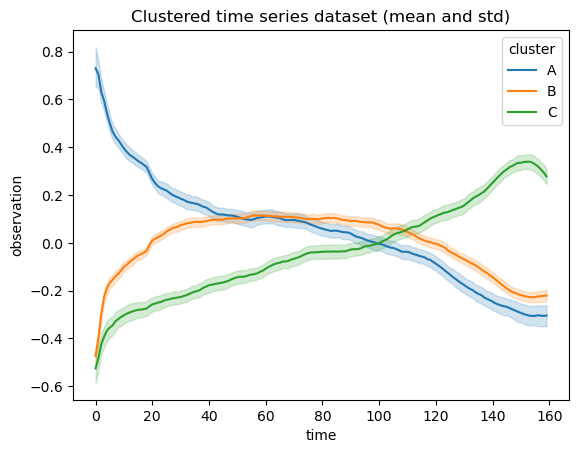

In [74]:
df_melt = df.melt(value_name="observation", var_name="time", id_vars="cluster")
sns.lineplot(df_melt, x="time", y="observation", hue="cluster")
plt.title("Clustered time series dataset (mean and std)")
plt.show()

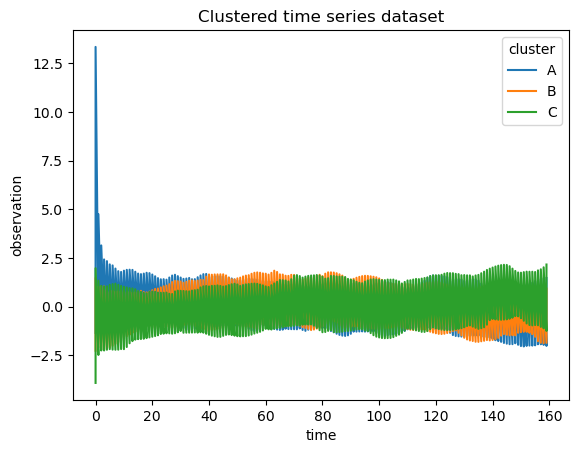

In [75]:
sns.lineplot(df_melt, x="time", y="observation", hue="cluster", estimator=None)
plt.title("Clustered time series dataset")
plt.show()

## Merge

In [76]:
df=pd.read_csv('df_melt_clustering.csv')

In [77]:
df

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,cluster,ids,genre
0,-1.353428,-0.546794,-0.098685,0.101814,0.223937,0.261562,0.289637,0.361519,0.428891,0.471332,...,-0.831243,-0.705048,-0.687467,-0.646836,-0.605104,-0.573687,-0.530191,A,3HUMNxBQoCPTg2K8wi7oFb,opera
1,1.829347,1.442539,1.223386,1.195228,1.041661,0.947683,0.882886,0.788565,0.769304,0.715932,...,-0.062360,-0.032037,-0.044786,-0.082636,-0.095932,-0.082223,-0.049814,A,0vgIkHFK8wpogVc1XCi18F,minimal-techno
2,-0.195280,-0.247879,-0.241994,0.118379,0.115157,0.073045,0.033403,-0.005680,0.050194,0.035791,...,-0.795621,-0.870820,-0.873177,-0.829184,-0.784024,-0.726989,-0.573973,B,0Av7W8Abdx761b2Ey5wo1u,goth
3,-0.947061,-0.904952,-0.924337,-1.080418,-1.193153,-1.154509,-1.069506,-0.990103,-0.882222,-0.761149,...,-1.193987,-1.254854,-1.343013,-1.393278,-1.425629,-1.477797,-1.519211,B,5KIuAOpwX3UHISVwuBhG2J,opera
4,0.504387,0.015058,0.188868,0.093976,0.054545,0.012403,0.173440,0.132284,0.092271,0.038390,...,-0.248212,-0.223383,-0.217135,-0.183620,-0.232359,-0.246961,-0.308267,A,1e6YswGTpMvjk21TQAxfXw,minimal-techno
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,-1.212961,-0.737953,-0.183323,0.116996,0.075086,-0.042308,-0.143252,-0.175555,-0.255698,-0.320746,...,0.046516,0.050586,0.066831,0.102512,0.151668,0.170286,0.214931,B,6LDocxGe28oGm8GvPq8Msv,songwriter
1996,0.052268,-0.295516,-0.507861,-0.387493,-0.287537,-0.268639,-0.145110,-0.199503,-0.220911,-0.195231,...,-0.190836,-0.197736,-0.209557,-0.196057,-0.220448,-0.232251,-0.197614,B,1sMoMqcOp0Rx7ObqDNs2Wp,salsa
1997,-2.052218,-1.906699,-1.784623,-1.691007,-1.656993,-1.572510,-1.285612,-0.970913,-0.778058,-0.651592,...,-0.189976,-0.178220,-0.156056,-0.073472,-0.006313,-0.056686,-0.101253,B,2lW5yKm8tZxLTleYMkyAft,salsa
1998,0.047299,0.171506,0.199233,0.394514,0.689799,0.588742,0.511637,0.486242,0.313850,0.229503,...,-0.111280,-0.123550,-0.164731,-0.217943,-0.192871,-0.184950,-0.155455,A,3JsLg8mtMCWmbxlvf7l768,salsa


In [78]:
dataset=pd.read_csv('nuovo_dataset_totale.csv')

In [79]:
dataset_merged = pd.merge(df, dataset, left_on=['ids', 'genre'], right_on=['id', 'genre'], how='inner')

In [80]:
dataset_merged

,0,1,2,3,4,5,6,7,8,9,...,liveness,valence,tempo,time_signature,tempo_confidence,time_signature_confidence,key_confidence,mode_confidence,n_bars,popularity_artist
0,-1.353428,-0.546794,-0.098685,0.101814,0.223937,0.261562,0.289637,0.361519,0.428891,0.471332,...,0.04,0.11,85.24,5.0,0.04,0.02,0.53,0.53,78.0,"[58.0, 52.0, 60.0, 48.0]"
1,1.829347,1.442539,1.223386,1.195228,1.041661,0.947683,0.882886,0.788565,0.769304,0.715932,...,0.09,0.18,120.00,4.0,0.70,0.60,1.00,0.96,112.0,"[56.0, 62.0]"
2,-0.195280,-0.247879,-0.241994,0.118379,0.115157,0.073045,0.033403,-0.005680,0.050194,0.035791,...,0.39,0.30,121.73,4.0,0.75,0.99,0.00,0.23,121.0,"[41.0, 19.0]"
3,-0.947061,-0.904952,-0.924337,-1.080418,-1.193153,-1.154509,-1.069506,-0.990103,-0.882222,-0.761149,...,0.11,0.07,65.63,4.0,0.03,0.42,0.69,0.67,69.0,"[56.0, 45.0, 45.0]"
4,0.504387,0.015058,0.188868,0.093976,0.054545,0.012403,0.173440,0.132284,0.092271,0.038390,...,0.12,0.65,86.35,4.0,0.22,1.00,0.23,0.27,99.0,[36.0]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,-1.212961,-0.737953,-0.183323,0.116996,0.075086,-0.042308,-0.143252,-0.175555,-0.255698,-0.320746,...,0.10,0.29,137.88,4.0,0.14,0.97,0.68,0.78,118.0,[65.0]
1996,0.052268,-0.295516,-0.507861,-0.387493,-0.287537,-0.268639,-0.145110,-0.199503,-0.220911,-0.195231,...,0.08,0.92,92.63,4.0,0.31,1.00,0.66,0.73,111.0,[55.0]
1997,-2.052218,-1.906699,-1.784623,-1.691007,-1.656993,-1.572510,-1.285612,-0.970913,-0.778058,-0.651592,...,0.12,0.75,91.79,4.0,0.15,0.86,0.25,0.43,111.0,[62.0]
1998,0.047299,0.171506,0.199233,0.394514,0.689799,0.588742,0.511637,0.486242,0.313850,0.229503,...,0.10,0.76,99.03,4.0,0.48,1.00,0.46,0.57,98.0,[66.0]


In [81]:
dataset_merged.columns.to_list()

['0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '40',
 '41',
 '42',
 '43',
 '44',
 '45',
 '46',
 '47',
 '48',
 '49',
 '50',
 '51',
 '52',
 '53',
 '54',
 '55',
 '56',
 '57',
 '58',
 '59',
 '60',
 '61',
 '62',
 '63',
 '64',
 '65',
 '66',
 '67',
 '68',
 '69',
 '70',
 '71',
 '72',
 '73',
 '74',
 '75',
 '76',
 '77',
 '78',
 '79',
 '80',
 '81',
 '82',
 '83',
 '84',
 '85',
 '86',
 '87',
 '88',
 '89',
 '90',
 '91',
 '92',
 '93',
 '94',
 '95',
 '96',
 '97',
 '98',
 '99',
 '100',
 '101',
 '102',
 '103',
 '104',
 '105',
 '106',
 '107',
 '108',
 '109',
 '110',
 '111',
 '112',
 '113',
 '114',
 '115',
 '116',
 '117',
 '118',
 '119',
 '120',
 '121',
 '122',
 '123',
 '124',
 '125',
 '126',
 '127',
 '128',
 '129',
 '130',
 '131',
 '132',
 '133',
 '134',
 '135',
 '136',
 '137',
 '138'

In [82]:
dataset_merged['cluster']

0       A
1       A
2       B
3       B
4       A
       ..
1995    B
1996    B
1997    B
1998    A
1999    C
Name: cluster, Length: 2000, dtype: object

In [83]:
# Lista delle variabili su cui calcolare la media
variabili_da_calcolare = ['popularity', 'energy', 'danceability', 'speechiness', 'key', 'loudness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo',
 'time_signature',
 'tempo_confidence',
 'time_signature_confidence',
 'key_confidence',
 'n_bars', 'album_total_tracks','speechiness']  # Aggiungi altre variabili se necessario

# Definizione dei cluster di interesse
clusters = ['A', 'B', 'C']

# Dizionario per memorizzare i risultati delle medie
risultati_medie = {}

# Iterazione su ogni variabile
for variabile in variabili_da_calcolare:
    # Per ogni variabile, creiamo un sotto-dizionario per memorizzare le medie per ciascun cluster
    risultati_medie_per_variabile = {}
    
    # Iterazione su ogni cluster
    for cluster in clusters:
        # Seleziona solo le righe relative al cluster specificato
        cluster_data = dataset_merged[dataset_merged['cluster'] == cluster]
        
        # Calcola la media della variabile per il cluster corrente
        media_variabile = cluster_data[variabile].mean()
        
        # Memorizza la media nel sotto-dizionario
        risultati_medie_per_variabile[cluster] = media_variabile
    
    # Memorizza i risultati per la variabile corrente nel dizionario principale
    risultati_medie[variabile] = risultati_medie_per_variabile

# Stampa dei risultati
for variabile, risultati_per_cluster in risultati_medie.items():
    print(f"Variabile: {variabile}")
    for cluster, media in risultati_per_cluster.items():
        print(f"Cluster {cluster}: Media {variabile}: {media}")
    print()


Variabile: popularity
Cluster A: Media popularity: 36.37632508833922
Cluster B: Media popularity: 34.03409090909091
Cluster C: Media popularity: 34.061371841155236

Variabile: energy
Cluster A: Media energy: 0.579664310954063
Cluster B: Media energy: 0.5831704545454546
Cluster C: Media energy: 0.6061732851985562

Variabile: danceability
Cluster A: Media danceability: 0.5112544169611306
Cluster B: Media danceability: 0.5407272727272727
Cluster C: Media danceability: 0.5241696750902525

Variabile: speechiness
Cluster A: Media speechiness: 0.06969964664310953
Cluster B: Media speechiness: 0.06871590909090906
Cluster C: Media speechiness: 0.06425992779783386

Variabile: key
Cluster A: Media key: 4.9628975265017665
Cluster B: Media key: 5.015909090909091
Cluster C: Media key: 5.171480144404332

Variabile: loudness
Cluster A: Media loudness: -10.374045936395765
Cluster B: Media loudness: -10.327534090909076
Cluster C: Media loudness: -10.290559566786996

Variabile: acousticness
Cluster A: Me

In [84]:
#df=df.drop(['cluster'], axis=1)

In [85]:
df

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,cluster,ids,genre
0,-1.353428,-0.546794,-0.098685,0.101814,0.223937,0.261562,0.289637,0.361519,0.428891,0.471332,...,-0.831243,-0.705048,-0.687467,-0.646836,-0.605104,-0.573687,-0.530191,A,3HUMNxBQoCPTg2K8wi7oFb,opera
1,1.829347,1.442539,1.223386,1.195228,1.041661,0.947683,0.882886,0.788565,0.769304,0.715932,...,-0.062360,-0.032037,-0.044786,-0.082636,-0.095932,-0.082223,-0.049814,A,0vgIkHFK8wpogVc1XCi18F,minimal-techno
2,-0.195280,-0.247879,-0.241994,0.118379,0.115157,0.073045,0.033403,-0.005680,0.050194,0.035791,...,-0.795621,-0.870820,-0.873177,-0.829184,-0.784024,-0.726989,-0.573973,B,0Av7W8Abdx761b2Ey5wo1u,goth
3,-0.947061,-0.904952,-0.924337,-1.080418,-1.193153,-1.154509,-1.069506,-0.990103,-0.882222,-0.761149,...,-1.193987,-1.254854,-1.343013,-1.393278,-1.425629,-1.477797,-1.519211,B,5KIuAOpwX3UHISVwuBhG2J,opera
4,0.504387,0.015058,0.188868,0.093976,0.054545,0.012403,0.173440,0.132284,0.092271,0.038390,...,-0.248212,-0.223383,-0.217135,-0.183620,-0.232359,-0.246961,-0.308267,A,1e6YswGTpMvjk21TQAxfXw,minimal-techno
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,-1.212961,-0.737953,-0.183323,0.116996,0.075086,-0.042308,-0.143252,-0.175555,-0.255698,-0.320746,...,0.046516,0.050586,0.066831,0.102512,0.151668,0.170286,0.214931,B,6LDocxGe28oGm8GvPq8Msv,songwriter
1996,0.052268,-0.295516,-0.507861,-0.387493,-0.287537,-0.268639,-0.145110,-0.199503,-0.220911,-0.195231,...,-0.190836,-0.197736,-0.209557,-0.196057,-0.220448,-0.232251,-0.197614,B,1sMoMqcOp0Rx7ObqDNs2Wp,salsa
1997,-2.052218,-1.906699,-1.784623,-1.691007,-1.656993,-1.572510,-1.285612,-0.970913,-0.778058,-0.651592,...,-0.189976,-0.178220,-0.156056,-0.073472,-0.006313,-0.056686,-0.101253,B,2lW5yKm8tZxLTleYMkyAft,salsa
1998,0.047299,0.171506,0.199233,0.394514,0.689799,0.588742,0.511637,0.486242,0.313850,0.229503,...,-0.111280,-0.123550,-0.164731,-0.217943,-0.192871,-0.184950,-0.155455,A,3JsLg8mtMCWmbxlvf7l768,salsa


In [86]:
df['cluster'].to_list()

['A',
 'A',
 'B',
 'B',
 'A',
 'B',
 'B',
 'A',
 'B',
 'B',
 'C',
 'B',
 'C',
 'B',
 'B',
 'B',
 'B',
 'B',
 'A',
 'B',
 'A',
 'A',
 'A',
 'A',
 'B',
 'B',
 'A',
 'B',
 'C',
 'A',
 'C',
 'B',
 'B',
 'A',
 'B',
 'C',
 'A',
 'B',
 'B',
 'C',
 'B',
 'B',
 'A',
 'B',
 'B',
 'A',
 'C',
 'C',
 'C',
 'B',
 'A',
 'A',
 'C',
 'B',
 'A',
 'A',
 'B',
 'B',
 'C',
 'B',
 'B',
 'C',
 'C',
 'C',
 'C',
 'C',
 'B',
 'A',
 'A',
 'A',
 'B',
 'C',
 'C',
 'B',
 'A',
 'C',
 'A',
 'A',
 'A',
 'C',
 'A',
 'A',
 'C',
 'A',
 'B',
 'B',
 'B',
 'C',
 'C',
 'A',
 'B',
 'B',
 'B',
 'B',
 'A',
 'B',
 'B',
 'C',
 'A',
 'B',
 'B',
 'A',
 'A',
 'B',
 'A',
 'B',
 'B',
 'C',
 'C',
 'B',
 'A',
 'C',
 'B',
 'A',
 'B',
 'B',
 'A',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'A',
 'C',
 'C',
 'A',
 'B',
 'B',
 'A',
 'B',
 'C',
 'C',
 'A',
 'B',
 'C',
 'A',
 'B',
 'C',
 'B',
 'C',
 'A',
 'B',
 'B',
 'B',
 'C',
 'A',
 'A',
 'A',
 'A',
 'B',
 'B',
 'C',
 'B',
 'B',
 'C',
 'C',
 'A',
 'B',
 'C',
 'B',
 'B',
 'B',
 'C',
 'B',
 'B',
 'C'

In [87]:
df=df.drop(['cluster'], axis=1)

In [88]:
df=df.drop(['ids'], axis=1)

In [89]:
df=df.drop(['genre'], axis=1)

In [90]:
from sklearn.decomposition import PCA

In [91]:
pca = PCA(n_components=2)
pca.fit(df)
X_train_pca = pca.transform(df)

In [92]:
X_train_pca

array([[-7.27816161, -2.17690791],
       [-1.216824  ,  3.60882738],
       [-3.1579456 , -1.73572843],
       ...,
       [ 0.94959135, -3.81627246],
       [-0.43518701,  1.75171524],
       [ 0.96345095, -0.34928567]])

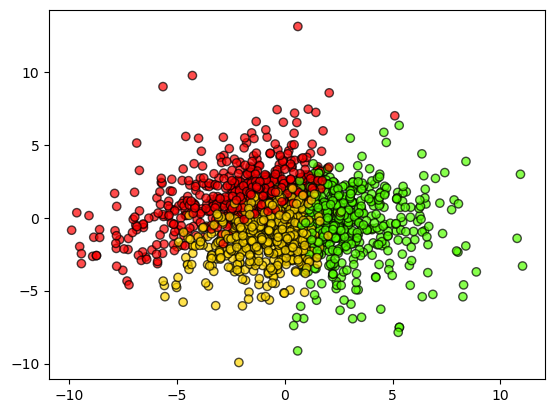

In [93]:
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=clusterer.labels_, 
            cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()


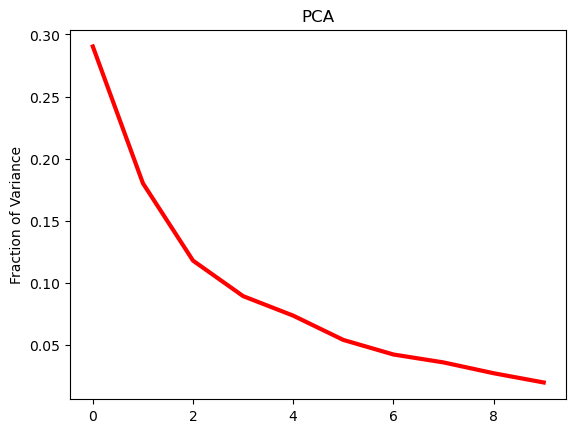

In [94]:
plt.plot(PCA(n_components=10).fit(df).explained_variance_ratio_, lw=3, color='r', ms=2)
plt.title("PCA")
plt.ylabel("Fraction of Variance")
plt.show()

## t-SNE

In [95]:
from sklearn.manifold import TSNE

In [96]:
tsne = TSNE(n_components=2)
X_train_tsne = tsne.fit_transform(df)
X_train_tsne.shape

/Users/isabelsantucci/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/isabelsantucci/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(2000, 2)

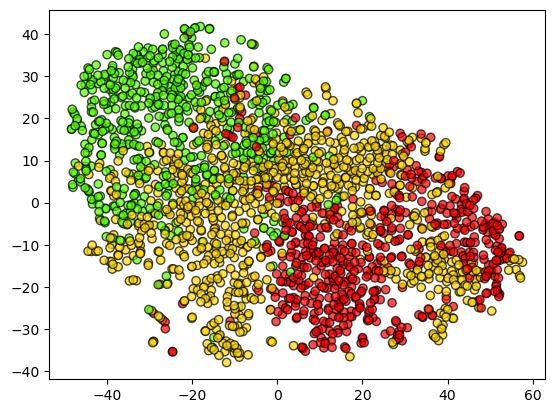

In [97]:
plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=clusterer.labels_, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()

## Summary Transformer Extractor

In [76]:
X

array([[[-1.35342846, -0.54679428, -0.09868485, ..., -0.60510409,
         -0.57368688, -0.53019092]],

       [[ 1.82934715,  1.44253884,  1.22338628, ..., -0.09593232,
         -0.08222257, -0.04981418]],

       [[-0.19527997, -0.24787918, -0.24199419, ..., -0.78402417,
         -0.7269895 , -0.57397279]],

       ...,

       [[-2.05221771, -1.90669871, -1.78462348, ..., -0.00631283,
         -0.0566858 , -0.10125349]],

       [[ 0.04729931,  0.17150614,  0.19923252, ..., -0.19287054,
         -0.18494962, -0.15545524]],

       [[-1.90984771, -1.35121918, -1.06456067, ..., -0.01308497,
          0.02295059,  0.03761901]]])

In [181]:
from sktime.transformations.series.summarize import SummaryTransformer
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA

In [182]:
transformer = SummaryTransformer() #altro modo calcolare le feature rispetto a quello sopra 

In [183]:
F_train = transformer.fit_transform(X)
F_train

,mean,std,min,max,0.1,0.25,0.5,0.75,0.9
instances,,,,,,,,,
0,0.011637,0.698437,-1.353428,1.001438,-1.085840,-0.681891,0.224912,0.614505,0.799103
1,0.062830,0.318947,-0.230987,1.829347,-0.147595,-0.094714,-0.035983,0.057036,0.425533
2,0.013116,0.371595,-0.873177,0.497845,-0.672221,-0.023588,0.119498,0.234445,0.405911
3,0.045059,0.731602,-1.519211,1.310399,-0.906890,-0.443903,-0.024054,0.529898,1.108555
4,0.028907,0.188405,-0.467883,0.504387,-0.299856,-0.019764,0.077808,0.161659,0.209195
...,...,...,...,...,...,...,...,...,...
1995,-0.043597,0.309247,-1.212961,0.764915,-0.420290,-0.207690,-0.033427,0.123765,0.294444
1996,0.000076,0.165691,-0.507861,0.398309,-0.219402,-0.101066,0.005704,0.091377,0.207598
1997,-0.058367,0.420345,-2.052218,0.434677,-0.335434,-0.149028,0.057564,0.137033,0.253302


In [ ]:
from sklearn.neighbors import NearestNeighbors
nn = NearestNeighbors(n_neighbors=5).fit(F_train)
distances, indices = nn.kneighbors(F_train)

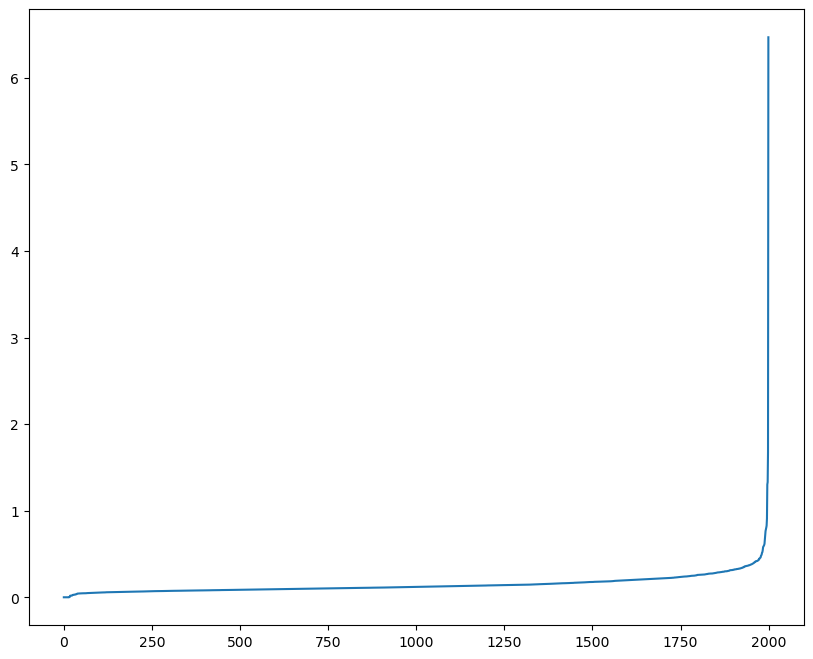

In [142]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(figsize=(10,8))
plt.plot(distances)

In [184]:
clusterer = DBSCAN(eps=0.5, min_samples=5)

In [185]:
clusterer.fit(F_train)

DBSCAN()

In [186]:
df=F_train.copy()

In [187]:
F_train["cluster"] = clusterer.labels_

In [188]:
F_train

,mean,std,min,max,0.1,0.25,0.5,0.75,0.9,cluster
instances,,,,,,,,,,
0,0.011637,0.698437,-1.353428,1.001438,-1.085840,-0.681891,0.224912,0.614505,0.799103,0
1,0.062830,0.318947,-0.230987,1.829347,-0.147595,-0.094714,-0.035983,0.057036,0.425533,0
2,0.013116,0.371595,-0.873177,0.497845,-0.672221,-0.023588,0.119498,0.234445,0.405911,0
3,0.045059,0.731602,-1.519211,1.310399,-0.906890,-0.443903,-0.024054,0.529898,1.108555,0
4,0.028907,0.188405,-0.467883,0.504387,-0.299856,-0.019764,0.077808,0.161659,0.209195,0
...,...,...,...,...,...,...,...,...,...,...
1995,-0.043597,0.309247,-1.212961,0.764915,-0.420290,-0.207690,-0.033427,0.123765,0.294444,0
1996,0.000076,0.165691,-0.507861,0.398309,-0.219402,-0.101066,0.005704,0.091377,0.207598,0
1997,-0.058367,0.420345,-2.052218,0.434677,-0.335434,-0.149028,0.057564,0.137033,0.253302,0


In [189]:
df

,mean,std,min,max,0.1,0.25,0.5,0.75,0.9
instances,,,,,,,,,
0,0.011637,0.698437,-1.353428,1.001438,-1.085840,-0.681891,0.224912,0.614505,0.799103
1,0.062830,0.318947,-0.230987,1.829347,-0.147595,-0.094714,-0.035983,0.057036,0.425533
2,0.013116,0.371595,-0.873177,0.497845,-0.672221,-0.023588,0.119498,0.234445,0.405911
3,0.045059,0.731602,-1.519211,1.310399,-0.906890,-0.443903,-0.024054,0.529898,1.108555
4,0.028907,0.188405,-0.467883,0.504387,-0.299856,-0.019764,0.077808,0.161659,0.209195
...,...,...,...,...,...,...,...,...,...
1995,-0.043597,0.309247,-1.212961,0.764915,-0.420290,-0.207690,-0.033427,0.123765,0.294444
1996,0.000076,0.165691,-0.507861,0.398309,-0.219402,-0.101066,0.005704,0.091377,0.207598
1997,-0.058367,0.420345,-2.052218,0.434677,-0.335434,-0.149028,0.057564,0.137033,0.253302


In [190]:
df["cluster"] = clusterer.labels_

In [193]:
df.columns

Index(['mean', 'std', 'min', 'max', '0.1', '0.25', '0.5', '0.75', '0.9',
       'cluster'],
      dtype='object')

In [191]:
df

,mean,std,min,max,0.1,0.25,0.5,0.75,0.9,cluster
instances,,,,,,,,,,
0,0.011637,0.698437,-1.353428,1.001438,-1.085840,-0.681891,0.224912,0.614505,0.799103,0
1,0.062830,0.318947,-0.230987,1.829347,-0.147595,-0.094714,-0.035983,0.057036,0.425533,0
2,0.013116,0.371595,-0.873177,0.497845,-0.672221,-0.023588,0.119498,0.234445,0.405911,0
3,0.045059,0.731602,-1.519211,1.310399,-0.906890,-0.443903,-0.024054,0.529898,1.108555,0
4,0.028907,0.188405,-0.467883,0.504387,-0.299856,-0.019764,0.077808,0.161659,0.209195,0
...,...,...,...,...,...,...,...,...,...,...
1995,-0.043597,0.309247,-1.212961,0.764915,-0.420290,-0.207690,-0.033427,0.123765,0.294444,0
1996,0.000076,0.165691,-0.507861,0.398309,-0.219402,-0.101066,0.005704,0.091377,0.207598,0
1997,-0.058367,0.420345,-2.052218,0.434677,-0.335434,-0.149028,0.057564,0.137033,0.253302,0


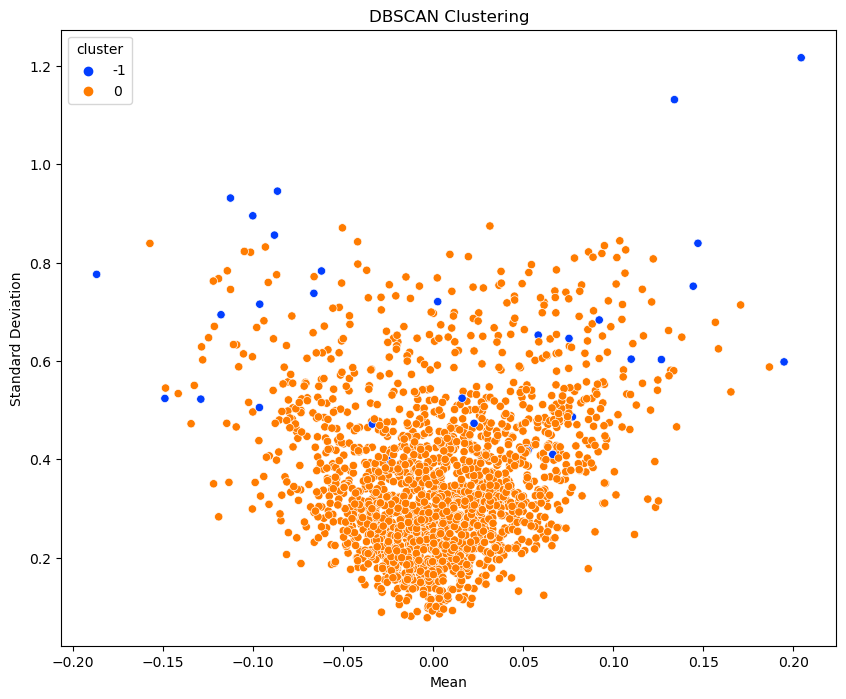

In [194]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualizzazione dei cluster
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df, x="mean", y="std", hue="cluster", palette="bright")
plt.title('DBSCAN Clustering')
plt.xlabel('Mean')
plt.ylabel('Standard Deviation')
plt.show()


## PCA

In [198]:
pca = PCA(n_components=2)
F_train_pca = pca.fit_transform(F_train)
F_train = pd.concat(
    [F_train, pd.DataFrame(F_train_pca, columns=["pca1", "pca2"])], axis=1
)

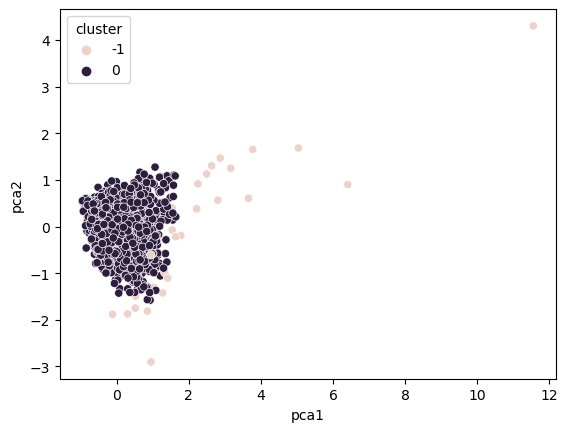

In [199]:
sns.scatterplot(F_train, x="pca1", y="pca2", hue="cluster") #pca dbscan non è molto ottimale, tutto nello stesso cluster
plt.show()

## TSNE

In [195]:
from sklearn.manifold import TSNE

In [196]:
tsne = TSNE(n_components=2)
X_train_tsne = tsne.fit_transform(df)
X_train_tsne.shape

/Users/isabelsantucci/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/isabelsantucci/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(2000, 2)

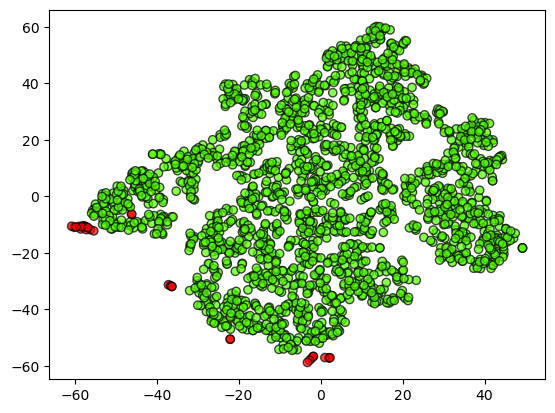

In [197]:
plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=clusterer.labels_, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()